<a href="https://colab.research.google.com/github/LoznianuAnamaria/challenges/blob/main/Ocean%20Discord%20Community%20Dynamics/Ocean_Discord.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import yfinance as yf
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
import re
from prophet import Prophet
from scipy.stats import linregress
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# Upload file from your local machine
uploaded = files.upload()
file_name = list(uploaded.keys())[0]  # Adjust the file name if necessary

# Load the data
data = pd.read_csv(file_name)

data.info()

Saving Ocean Discord Data Challenge Dataset.csv to Ocean Discord Data Challenge Dataset (1).csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84754 entries, 0 to 84753
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Channel      84754 non-null  object
 1   AuthorID     84754 non-null  int64 
 2   Author       84754 non-null  object
 3   Date         84754 non-null  object
 4   Content      64609 non-null  object
 5   Attachments  1959 non-null   object
 6   Reactions    6073 non-null   object
dtypes: int64(1), object(6)
memory usage: 4.5+ MB



# Data preprocessing

In [ ]:
# Separate the Channel name and ID, and remove extra brackets
if 'Channel' in data.columns:
  data[['ChannelName', 'ChannelID']] = data['Channel'].str.extract(r'(.+) \[([0-9]+)\]')
  data.drop(columns=['Channel'], inplace=True)

# Clean up author column
if 'Author' in data.columns:
  data['AuthorName'] = data['Author']
  data.drop(columns=['Author'], inplace=True)

# Reorder the columns
columns_ordered = ['ChannelName', 'ChannelID', 'AuthorName', 'AuthorID', 'Date', 'Content', 'Reactions', 'Attachments']  # Specify your desired order
cleaned_data = data[columns_ordered].copy()

# Extract more info from the Date column
cleaned_data['Date'] = pd.to_datetime(cleaned_data['Date'], format='%m/%d/%Y %I:%M %p')
cleaned_data['Date_Only'] = cleaned_data['Date'].dt.date
cleaned_data['Time'] = cleaned_data['Date'].dt.time
cleaned_data['Year'] = cleaned_data['Date'].dt.year
cleaned_data['Hour'] = cleaned_data['Date'].dt.hour
cleaned_data['DayOfWeek'] = cleaned_data['Date'].dt.dayofweek

cleaned_data.rename(columns={'Date': 'DateTime'}, inplace=True)
cleaned_data.rename(columns={'Date_Only': 'Date'}, inplace=True)

cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84754 entries, 0 to 84753
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   ChannelName  84754 non-null  object        
 1   ChannelID    84754 non-null  object        
 2   AuthorName   84754 non-null  object        
 3   AuthorID     84754 non-null  int64         
 4   DateTime     84754 non-null  datetime64[ns]
 5   Content      64609 non-null  object        
 6   Reactions    6073 non-null   object        
 7   Attachments  1959 non-null   object        
 8   Date         84754 non-null  object        
 9   Time         84754 non-null  object        
 10  Year         84754 non-null  int64         
 11  Hour         84754 non-null  int64         
 12  DayOfWeek    84754 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(8)
memory usage: 8.4+ MB


## Content preprocessing

In [ ]:
# Remove rows that don't have content
df = cleaned_data[cleaned_data['Content'].notna()].copy()

# Remove rows where the Author is a bot
bots = ['GitHub', 'MEE6#4876', 'OceanDiffusion#4502', 'OceanGPT#0740', 'Ocean Protocol • TweetShift']
df = df[~df['AuthorName'].isin(bots)]

# Remove rows for people that just joined
join_messages = ['Joined the server.']
df = df[~df['Content'].isin(join_messages)]

# Remove the GM and Github channels from the analysis
filtered_channels = ['911643560594505809', '773926934601269248']
df = df[~df['ChannelID'].isin(filtered_channels)]

# Transform the date field
df['Date'] = pd.to_datetime(df['Date'])

# Extract info from the content sent, the attachment and reactions
df['WordCount'] = df['Content'].apply(lambda x: len(str(x).split()))
df['CharCount'] = df['Content'].apply(lambda x: len(str(x)))
df['HasAttachment'] = ~df['Attachments'].isna()
df['ReactionCount'] = df['Reactions'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)

df.head()

,ChannelName,ChannelID,AuthorName,AuthorID,DateTime,Content,Reactions,Attachments,Date,Time,Year,Hour,DayOfWeek,WordCount,CharCount,HasAttachment,ReactionCount
0,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,mantisclone,369700858742571008,2023-03-29 01:02:00,gm 👋 :Water_Wave: :Oceancopy:,NaN,NaN,2023-03-29,01:02:00,2023,1,2,4,29,False,0
1,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,white_rider_,843831770062913568,2023-03-29 16:37:00,Good morning to all the @🧑‍💻Builder 🌊,NaN,NaN,2023-03-29,16:37:00,2023,16,2,7,37,False,0
2,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,Maki#4920,563434444321587202,2023-03-29 16:37:00,**@White Rider just advanced to level 4!**,powerup (1),https://cdn.discordapp.com/attachments/1088751...,2023-03-29,16:37:00,2023,16,2,7,42,True,1
3,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,robinlehmann,194817764236460034,2023-03-29 16:40:00,https://tenor.com/view/hello-there-baby-yoda-m...,babyyodasoup (1),NaN,2023-03-29,16:40:00,2023,16,2,1,75,False,1
4,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,birususama,387401160656683034,2023-03-29 16:40:00,Good morning everyone 😀,🌅 (1),NaN,2023-03-29,16:40:00,2023,16,2,4,23,False,1


## Download Ocean Token Price


In [ ]:
# Determine the first date
start_date = df['Date'].min()

# Download Ocean token price history from Yahoo Finance
ocean_data = yf.download('OCEAN-USD', start=start_date)

ocean_prices = ocean_data[['Close']].rename(columns={'Close': 'OceanPrice'}).reset_index()

# Convert 'Date' in ocean_prices to date format to ensure matching format for merging
ocean_prices['Date'] = pd.to_datetime(ocean_prices['Date'])

raw_dataset = pd.merge(df, ocean_prices, how='left', on='Date')

# Reordering the dataset
new_order = ['OceanPrice', 'Date', 'Time', 'ChannelName', 'ChannelID',
             'AuthorName', 'AuthorID', 'WordCount', 'CharCount', 'ReactionCount', 'HasAttachment',
             'DateTime', 'Content', 'Reactions',
             'Attachments', 'Year', 'Hour', 'DayOfWeek']

# Reordering the columns
dataset = raw_dataset[new_order]

# Display and save the updated DataFrame info
dataset.to_csv('chat_and_price_history.csv', index=False)
dataset.head()

[*********************100%%**********************]  1 of 1 completed


,OceanPrice,Date,Time,ChannelName,ChannelID,AuthorName,AuthorID,WordCount,CharCount,ReactionCount,HasAttachment,DateTime,Content,Reactions,Attachments,Year,Hour,DayOfWeek
0,0.354217,2023-03-29,01:02:00,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,mantisclone,369700858742571008,4,29,0,False,2023-03-29 01:02:00,gm 👋 :Water_Wave: :Oceancopy:,NaN,NaN,2023,1,2
1,0.354217,2023-03-29,16:37:00,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,white_rider_,843831770062913568,7,37,0,False,2023-03-29 16:37:00,Good morning to all the @🧑‍💻Builder 🌊,NaN,NaN,2023,16,2
2,0.354217,2023-03-29,16:37:00,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,Maki#4920,563434444321587202,7,42,1,True,2023-03-29 16:37:00,**@White Rider just advanced to level 4!**,powerup (1),https://cdn.discordapp.com/attachments/1088751...,2023,16,2
3,0.354217,2023-03-29,16:40:00,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,robinlehmann,194817764236460034,1,75,1,False,2023-03-29 16:40:00,https://tenor.com/view/hello-there-baby-yoda-m...,babyyodasoup (1),NaN,2023,16,2
4,0.354217,2023-03-29,16:40:00,Ocean Protocol - CORE-TECH - 🌊┃builders,1088751449271447552,birususama,387401160656683034,4,23,1,False,2023-03-29 16:40:00,Good morning everyone 😀,🌅 (1),NaN,2023,16,2


# General Trends



*   Weekly
*   Monthly
*   Quarterly
*   Yearly
*   Seasonal



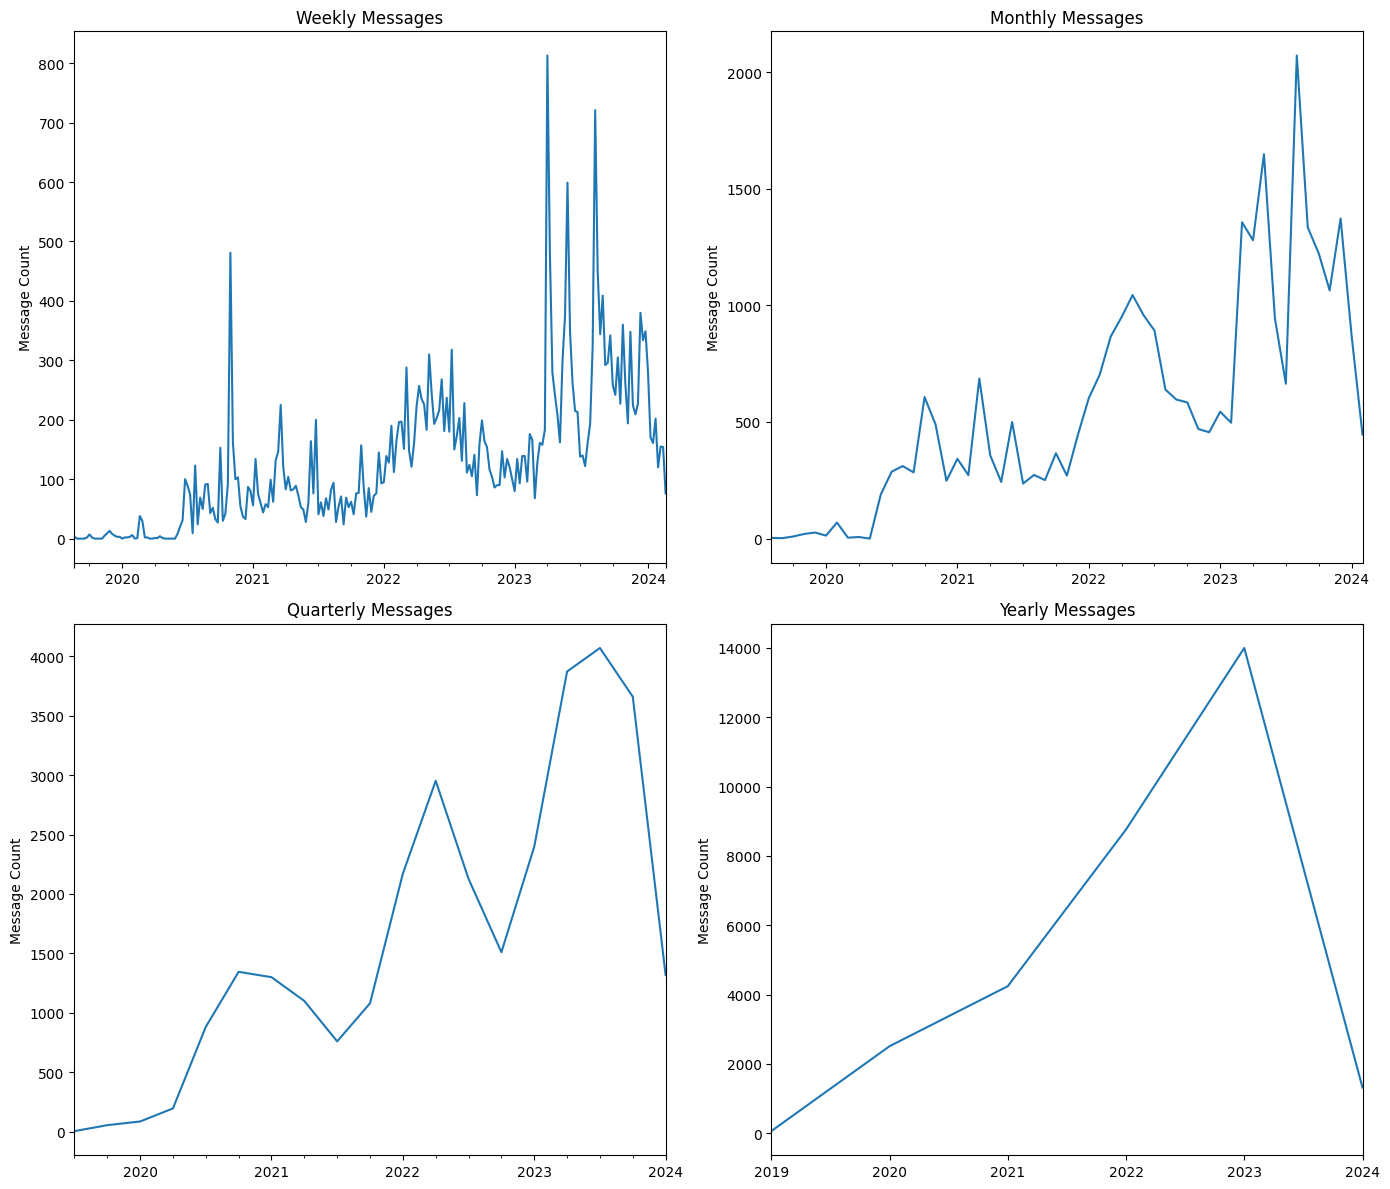

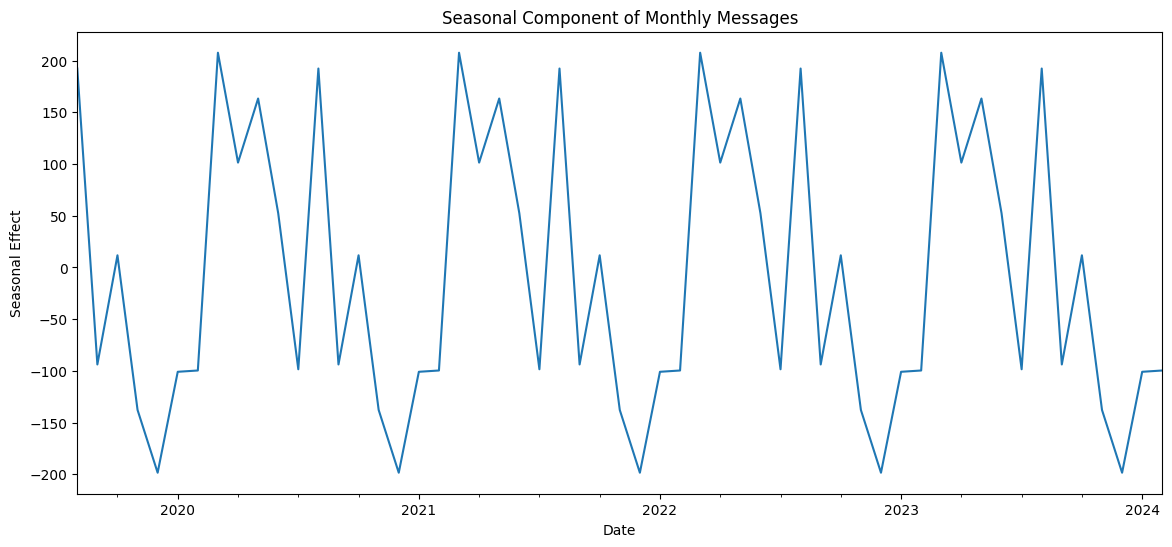

In [ ]:
# Check if 'Date' column exists and then set it as the index
if 'Date' in dataset.columns:
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.set_index('Date', inplace=True)

# Resample the data to different time bases: weekly, monthly, quarterly, and yearly
weekly_messages = dataset['Content'].resample('W').count()
monthly_messages = dataset['Content'].resample('M').count()
quarterly_messages = dataset['Content'].resample('Q').count()
yearly_messages = dataset['Content'].resample('A').count()

# Plotting in a 2x2 grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 12))  # Adjusted for a 2x2 grid

# Plot each time series in its own subplot
weekly_messages.plot(ax=axes[0, 0], title='Weekly Messages')
monthly_messages.plot(ax=axes[0, 1], title='Monthly Messages')
quarterly_messages.plot(ax=axes[1, 0], title='Quarterly Messages')
yearly_messages.plot(ax=axes[1, 1], title='Yearly Messages')
decomposition = seasonal_decompose(monthly_messages, model='additive')

# Setting the labels for x and y axes
axes[0, 0].set(xlabel='', ylabel='Message Count')
axes[0, 1].set(xlabel='', ylabel='Message Count')
axes[1, 0].set(xlabel='', ylabel='Message Count')
axes[1, 1].set(xlabel='', ylabel='Message Count')

plt.tight_layout()
plt.show()

# Plotting the seasonal component
plt.figure(figsize=(14, 6))
decomposition.seasonal.plot(title='Seasonal Component of Monthly Messages')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.show()

## Trend line

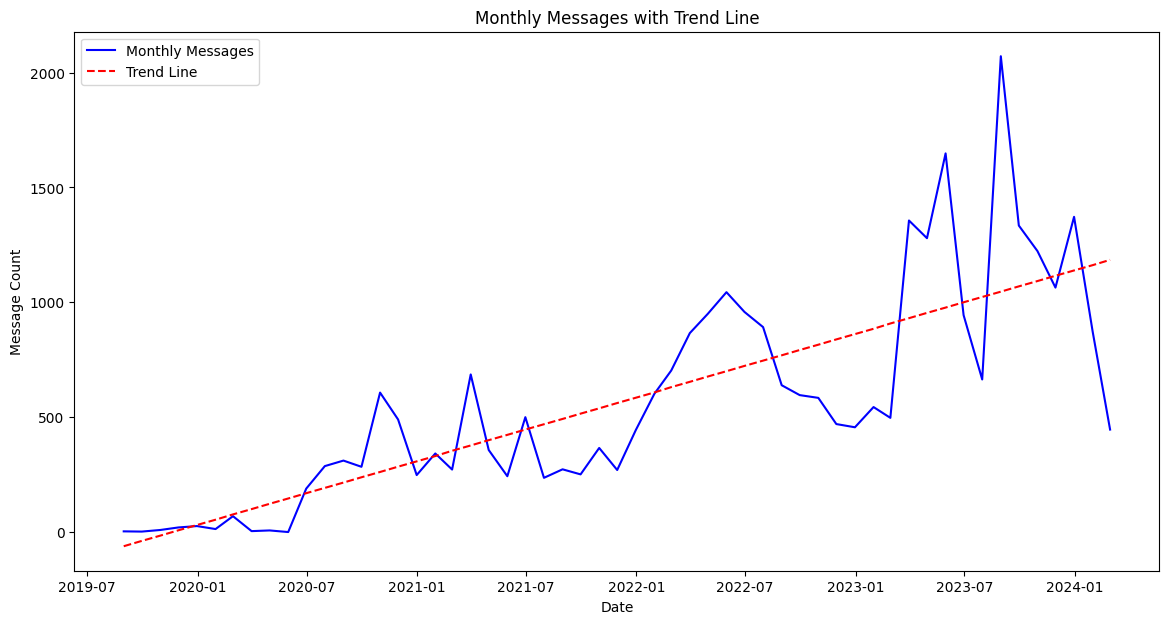

(23.08189033189032, 6.050713364144849e-13)

In [ ]:
# Extracting numerical indices for linear regression
x = np.arange(len(monthly_messages))
y = monthly_messages.values

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Generate values for the trend line
trend_line = intercept + slope * x

# Plotting the monthly messages with the trend line
plt.figure(figsize=(14, 7))
plt.plot(monthly_messages.index, monthly_messages, label='Monthly Messages', color='blue')
plt.plot(monthly_messages.index, trend_line, label='Trend Line', color='red', linestyle='--')
plt.title('Monthly Messages with Trend Line')
plt.xlabel('Date')
plt.ylabel('Message Count')
plt.legend()
plt.show()

# Returning the slope and p-value to interpret the trend and its statistical significance
slope, p_value

## Outlier Periods


**Outlier Periods:**
Notable dates with unusually high numbers of messages include:

* April 17, 2021: 7 messages
* May 4, 2021: 10 messages
* July 5-6 and 8, 2022: 242 messages
* August 6-7 and 11, 2022: 200 messages
* March 29-30, 2023: 575 messages
*  May 23, 2023: 261 messages



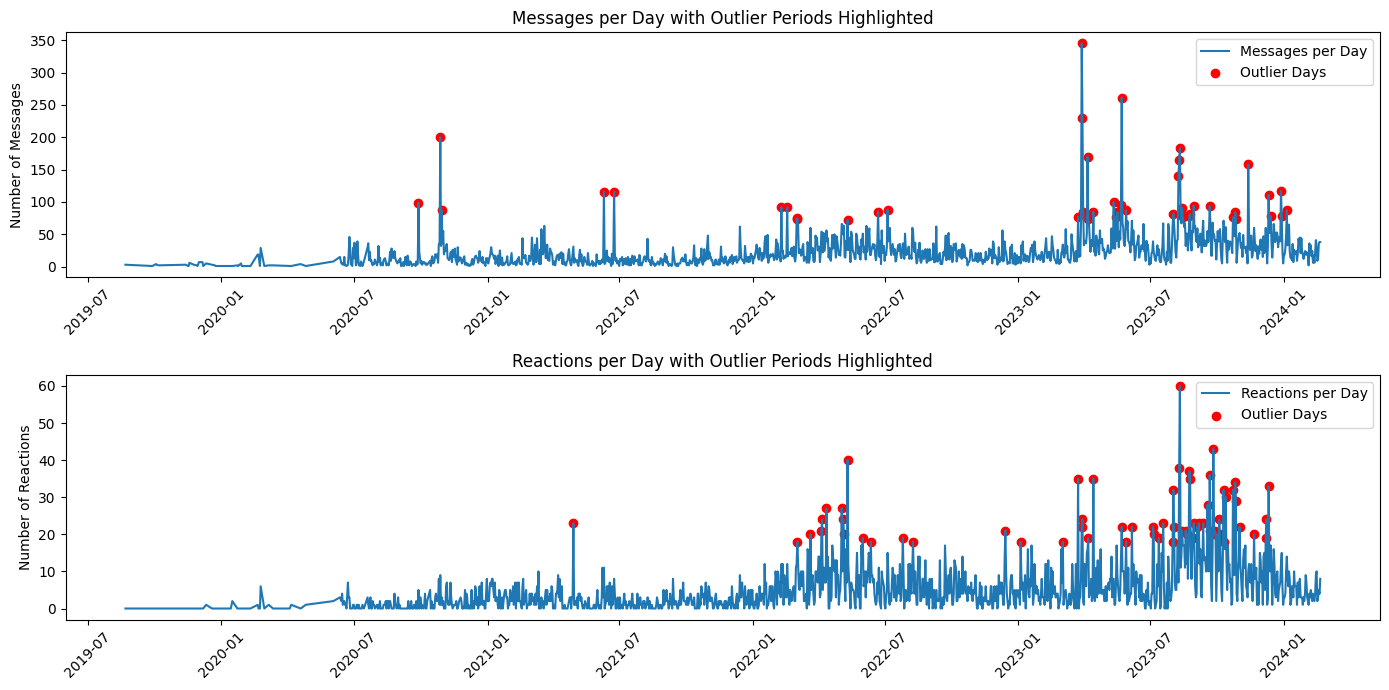

In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Count the number of messages per day
messages_per_day = dataset.groupby('Date').size()
reactions_per_day = dataset.groupby('Date')['ReactionCount'].sum()

# Merge message and reaction counts into a single DataFrame
interaction_data = pd.DataFrame({
    'Messages': messages_per_day,
    'Reactions': reactions_per_day
})

# Identify outlier periods using Z-score for both messages and reactions
from scipy.stats import zscore

interaction_data['Messages_Z'] = zscore(interaction_data['Messages'])
interaction_data['Reactions_Z'] = zscore(interaction_data['Reactions'])

# Consider periods where Z-score is above a certain threshold as outliers (absolute value for catching both high and low)
threshold = 2  # Commonly used threshold for identifying outliers
outlier_periods_messages = interaction_data[abs(interaction_data['Messages_Z']) > threshold]
outlier_periods_reactions = interaction_data[abs(interaction_data['Reactions_Z']) > threshold]

# Plot the data with outlier periods highlighted
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(interaction_data.index, interaction_data['Messages'], label='Messages per Day')
plt.scatter(outlier_periods_messages.index, outlier_periods_messages['Messages'], color='red', label='Outlier Days')
plt.title('Messages per Day with Outlier Periods Highlighted')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(interaction_data.index, interaction_data['Reactions'], label='Reactions per Day')
plt.scatter(outlier_periods_reactions.index, outlier_periods_reactions['Reactions'], color='red', label='Outlier Days')
plt.title('Reactions per Day with Outlier Periods Highlighted')
plt.ylabel('Number of Reactions')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

# Return the dates considered as outliers for both messages and reactions
outlier_dates = {
    'Messages_Outliers': outlier_periods_messages.index.tolist(),
    'Reactions_Outliers': outlier_periods_reactions.index.tolist()
}

## Outlier periods potential causes

* April - May 2021
Security: Frequent mentions of "warning," "scam," "account," "click," "links," and "validator" suggest discussions around security warnings and scam alerts. Also, a potential cause -  This period is around new partnership announcements and the [Gaia-X announcement](https://blog.oceanprotocol.com/ocean-datarella-and-the-future-of-mobility-data-sovereignty-with-gaia-x-95bdf8f89cc4).

* July 2022
Data and Ocean Protocol: The terms "ocean," "data," "dataset," and "pool" point towards the Ocean Onda release and the [draining pool attack](https://medium.com/oceanprotocol/ocean-market-changes-3384fd7e113c) that happened.

* August 2022
Ocean Protocol and Data: Similar to July, with frequent mentions of "ocean," "data," and specific references to "users," "eth" (Ethereum), and "epoch".

* March  2023
OceanDiffusion and OceanGPT: Dominated by mentions of "oceandiffusion," "oceangpt," "ocean," and "protocol," reflecting engagement with the newly added tool.

* May 23 2023
Community and Wallet Discussions: Common words include "just," "im" (I'm), "ocean," "wallet," "discord," and "airdrop,". This might be related to the Discord attack and also to the control over the [OCEAN contract](https://medium.com/oceanprotocol/control-over-the-ocean-contract-to-be-revoked-soon-technical-77cb8923171).

In [ ]:
from collections import Counter
import re

if 'Date' not in dataset.columns:
  dataset.reset_index(inplace=True)

# Define the periods of interest
periods = [
    {'start': '2021-04-17', 'end': '2021-04-17'},
    {'start': '2021-05-04', 'end': '2021-05-04'},
    {'start': '2022-07-05', 'end': '2022-07-08'},
    {'start': '2022-08-06', 'end': '2022-08-11'},
    {'start': '2023-03-29', 'end': '2023-03-30'},
    {'start': '2023-05-23', 'end': '2023-05-23'}
]

# Extract messages from these periods
messages_per_period = {}

for period in periods:
    start_date = pd.to_datetime(period['start'])
    end_date = pd.to_datetime(period['end'])
    period_key = f"{period['start']} to {period['end']}"
    filtered_data = dataset[(dataset['Date'] >= start_date) & (dataset['Date'] <= end_date)]
    messages_per_period[period_key] = filtered_data['Content'].tolist()

# Output the number of messages extracted for each period to ensure data was correctly filtered
{period: len(messages) for period, messages in messages_per_period.items()}


# Function to clean and tokenize message content
def clean_and_tokenize(text):
    # Remove URLs, special characters, and numbers
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Tokenize by splitting the text
    tokens = text.split()
    return tokens

# Analyze common words in each period, excluding some common stopwords to improve relevance
stopwords = set(['the', 'to', 'and', 'of', 'in', 'a', 'is', 'that', 'for', 'on', 'it', 'with', 'as', 'this', 'by', 'are', 'be', 'or', 'was', 'which', 'at', 'from', 'have', 'has', 'an', 'but', 'not', 'we', 'they', 'you', 'your', 'all', 'will', 'can', 'their', 'if', 'been', 'about', 'more', 'one', 'also', 'can', 'when', 'there', 'so', 'what', 'how', 'do', 'i', 'my'])

common_words_per_period = {}

for period, messages in messages_per_period.items():
    all_tokens = []
    for message in messages:
        tokens = clean_and_tokenize(message)
        # Filter out stopwords
        tokens = [token for token in tokens if token not in stopwords]
        all_tokens.extend(tokens)
    word_counts = Counter(all_tokens).most_common(10)  # Get the 10 most common words
    common_words_per_period[period] = word_counts

common_words_per_period



{'2021-04-17 to 2021-04-17': [('warning', 2),
  ('here', 2),
  ('scam', 2),
  ('account', 2),
  ('click', 2),
  ('any', 2),
  ('links', 2),
  ('validator', 2),
  ('got', 2),
  ('nivler', 1)],
 '2021-05-04 to 2021-05-04': [('hey', 3),
  ('here', 3),
  ('guys', 2),
  ('am', 2),
  ('time', 2),
  ('who', 1),
  ('happen', 1),
  ('today', 1),
  ('hows', 1),
  ('going', 1)],
 '2022-07-05 to 2022-07-08': [('ocean', 42),
  ('data', 37),
  ('here', 20),
  ('dataset', 17),
  ('pool', 15),
  ('just', 14),
  ('hi', 14),
  ('would', 14),
  ('im', 13),
  ('out', 13)],
 '2022-08-06 to 2022-08-11': [('ocean', 53),
  ('here', 19),
  ('hi', 16),
  ('data', 15),
  ('users', 14),
  ('eth', 14),
  ('august', 13),
  ('utc', 13),
  ('any', 12),
  ('epoch', 12)],
 '2023-03-29 to 2023-03-30': [('oceandiffusion', 227),
  ('oceangpt', 87),
  ('ocean', 55),
  ('protocol', 32),
  ('image', 25),
  ('lol', 22),
  ('me', 22),
  ('god', 21),
  ('rd', 20),
  ('like', 19)],
 '2023-05-23 to 2023-05-23': [('just', 22),
  (

## Peak activity times

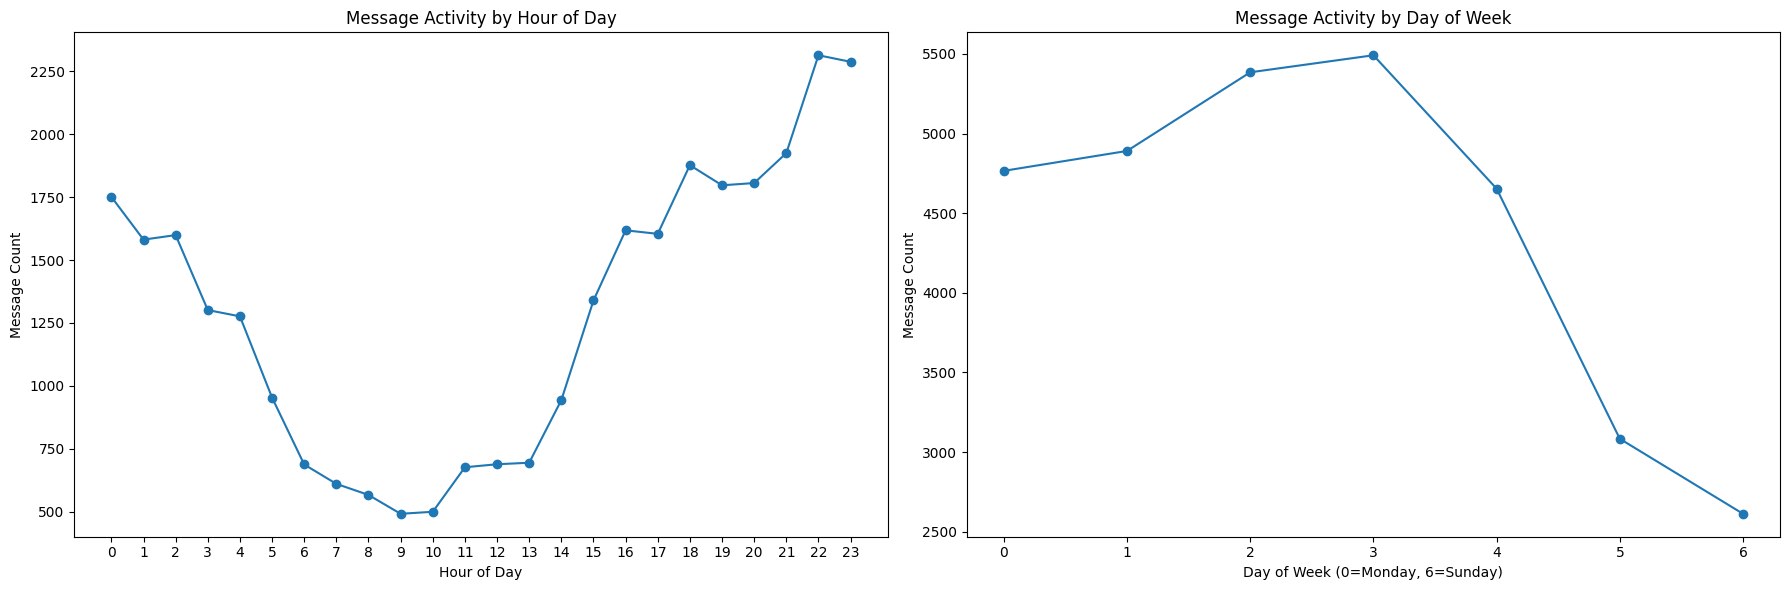

In [ ]:
# Aggregating message counts by hour of the day
hourly_activity = dataset.groupby('Hour').size()

# Aggregating message counts by day of the week
weekly_activity = dataset.groupby('DayOfWeek').size()

fig, ax = plt.subplots(1, 2, figsize=(18, 6))

# Hourly activity
ax[0].plot(hourly_activity.index, hourly_activity.values, marker='o', linestyle='-')
ax[0].set_title('Message Activity by Hour of Day')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Message Count')
ax[0].set_xticks(np.arange(0, 24, 1))

# Weekly activity
ax[1].plot(weekly_activity.index, weekly_activity.values, marker='o', linestyle='-')
ax[1].set_title('Message Activity by Day of Week')
ax[1].set_xlabel('Day of Week (0=Monday, 6=Sunday)')
ax[1].set_ylabel('Message Count')
ax[1].set_xticks(np.arange(0, 7, 1))

plt.tight_layout()
plt.show()


## Channel Trends


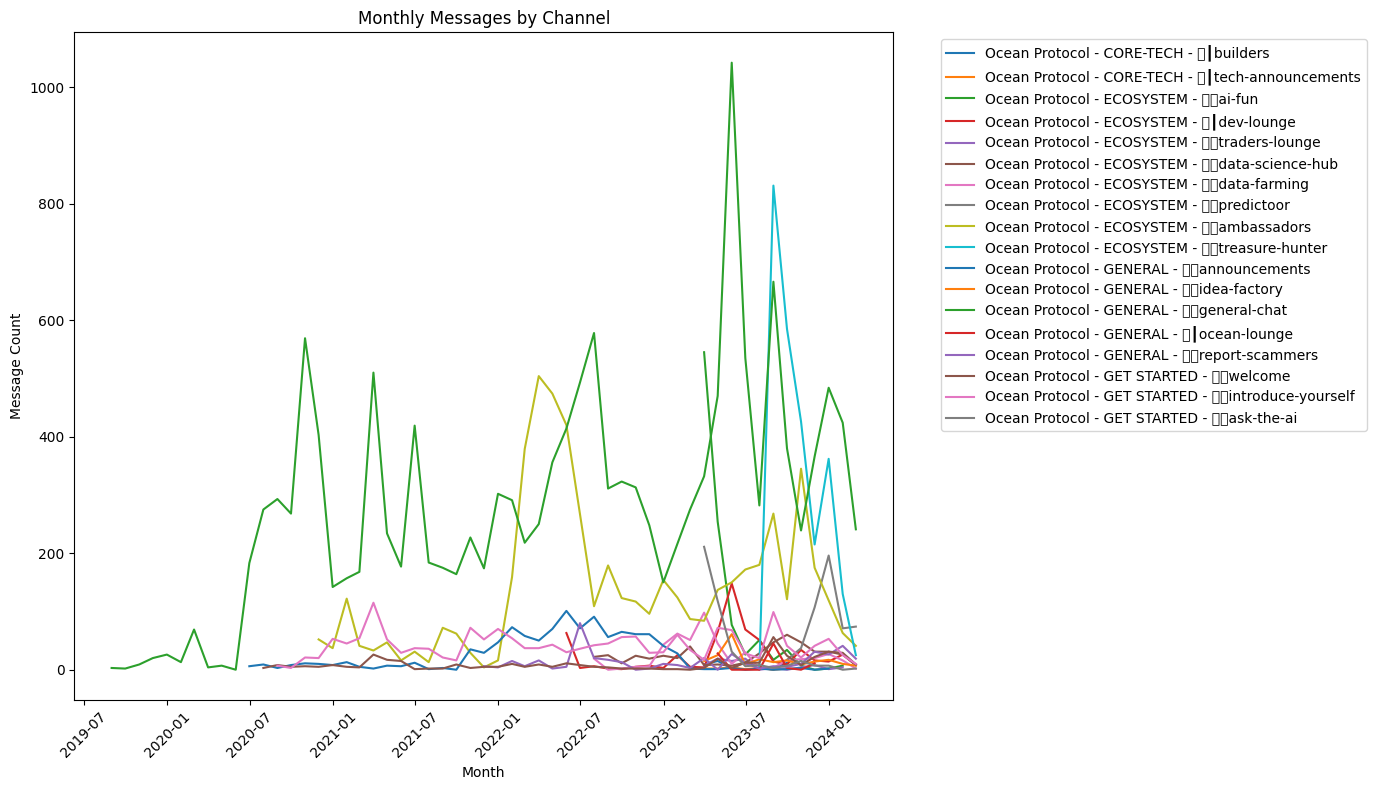

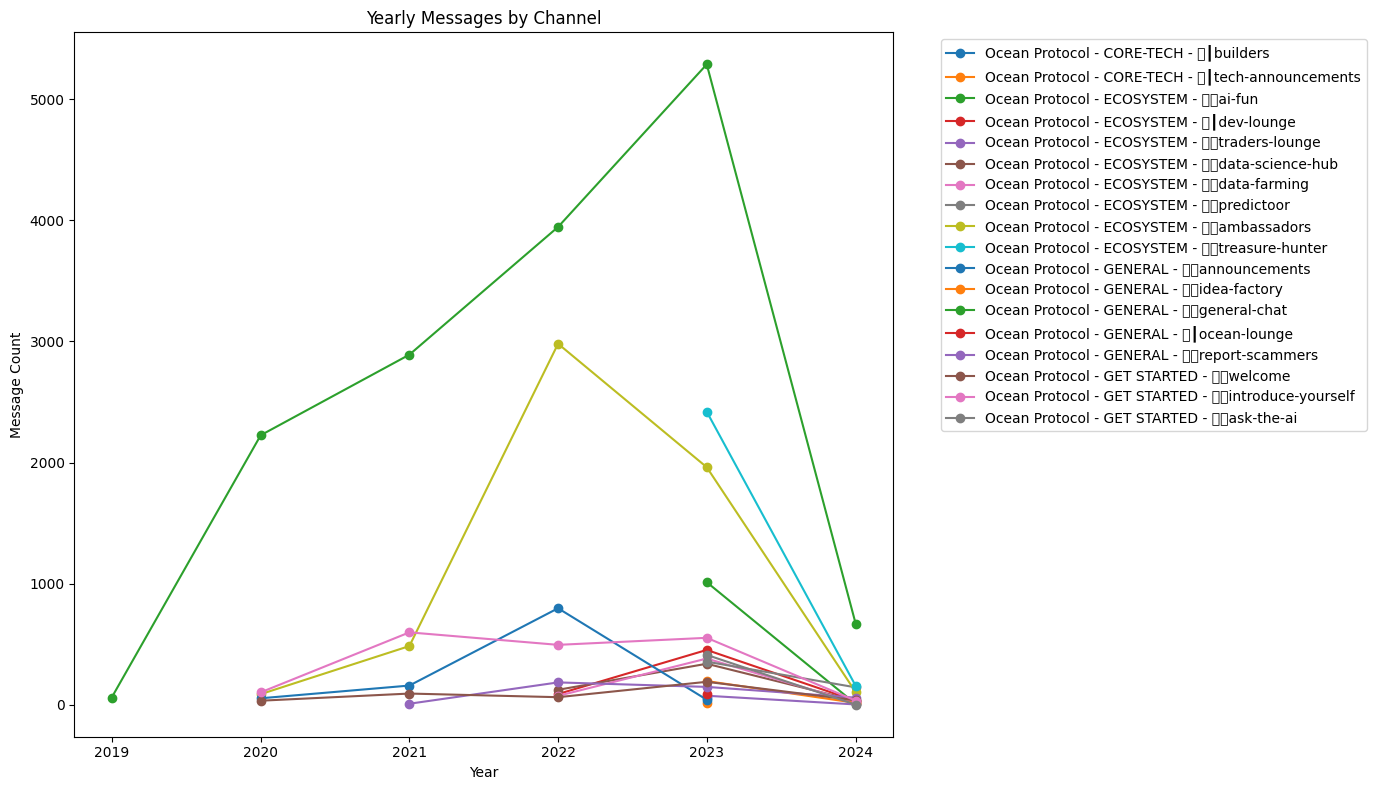

In [ ]:
# Ignore specific UserWarnings related to missing glyphs(fonts)
warnings.filterwarnings('ignore', 'Glyph .*')

if 'Date' in dataset.columns:
    dataset['Date'] = pd.to_datetime(dataset['Date'])
    dataset.set_index('Date')

# Group by ChannelName and resample by month, counting messages
monthly_messages_by_channel = dataset.groupby('ChannelName').resample('M')['Content'].count().unstack(level=0)
yearly_messages_by_channel = dataset.groupby('ChannelName').resample('Y')['Content'].count().unstack(level=0)

# Monthly message counts by channel, already computed
# Plotting monthly trends again for clarity
plt.figure(figsize=(14, 8))
for channel in monthly_messages_by_channel.columns:
    plt.plot(monthly_messages_by_channel.index, monthly_messages_by_channel[channel], label=channel)

plt.title('Monthly Messages by Channel')
plt.xlabel('Month')
plt.ylabel('Message Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Yearly message counts by channel, already computed
# Plotting yearly trends again for clarity
plt.figure(figsize=(14, 8))
for channel in yearly_messages_by_channel.columns:
    plt.plot(yearly_messages_by_channel.index, yearly_messages_by_channel[channel], label=channel, marker='o')

plt.title('Yearly Messages by Channel')
plt.xlabel('Year')
plt.ylabel('Message Count')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(yearly_messages_by_channel.index, labels=[x.year for x in yearly_messages_by_channel.index])
plt.tight_layout()
plt.show()

# Correlations


The price of $OCEAN has a slight negative correlation with both the number of messages (-0.12) and active users (-0.13), suggesting that price movements are not strongly associated with daily activity levels in terms of messages and user participation on the platform.

Interestingly, the price of $OCEAN has a slight positive correlation with new users (0.09), indicating that days with a higher influx of new users might see a different or slightly positive price movement, although this correlation is weak.

There is a strong positive correlation between the number of messages and active users (0.76), which is intuitive as more active users typically lead to more messages.

New users also show a positive correlation with the number of messages (0.50) and active users (0.62), suggesting that an increase in new users is associated with higher overall activity on the server.

These insights suggest that while day-to-day activity levels in terms of messaging and user engagement show some association with the price of $OCEAN, the relationships are not strongly positive or negative, indicating other factors might play a more significant role in price movements.

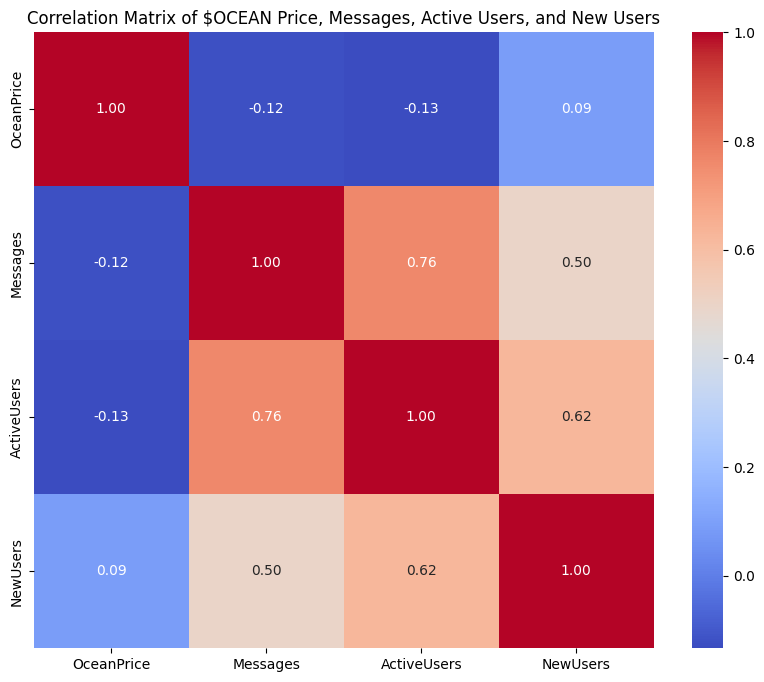

In [ ]:
if 'Date' not in dataset.columns:
  dataset = dataset.reset_index(inplace=True)

# Aggregate daily data
daily_data = dataset.groupby(dataset['DateTime'].dt.date).agg(
    OceanPrice=('OceanPrice', 'mean'),  # Average price of $OCEAN per day
    Messages=('Content', 'count'),  # Total number of messages per day
    ActiveUsers=('AuthorID', lambda x: x.nunique()),  # Unique authors per day
).reset_index()

# Identify new users per day
# Sort the data by datetime to ensure correct processing of first appearances
data_sorted = dataset.sort_values(by='DateTime')
data_sorted['IsNewUser'] = ~data_sorted['AuthorID'].duplicated()
new_users_daily = data_sorted.groupby(data_sorted['DateTime'].dt.date)['IsNewUser'].sum().reset_index()

# Merge the new users data with the other daily data
daily_data = pd.merge(daily_data, new_users_daily, how='left').drop(columns=['DateTime'])
daily_data.rename(columns={'IsNewUser': 'NewUsers'}, inplace=True)

# Calculate the correlation matrix
correlation_matrix = daily_data[['OceanPrice', 'Messages', 'ActiveUsers', 'NewUsers']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of $OCEAN Price, Messages, Active Users, and New Users')
plt.show()

#  Community questions

* Technical: Shows consistent engagement across years, highlighting a sustained interest in technical aspects of the project.
* General Information and Socializing: These categories also show substantial activity, reflecting the community's need for information and social interaction.
* Price-related: Interest in price-related discussions appears stable, reflecting ongoing interest in the financial aspects of the project.
* Project-related, Community and Events, Ambassadors, and Tokenomics: These categories show varying levels of engagement over the years, possibly correlating with specific project phases, events, or initiatives.
* AI Tools: A new category in 2023, indicating a recent focus or development within the community related to AI technologies.

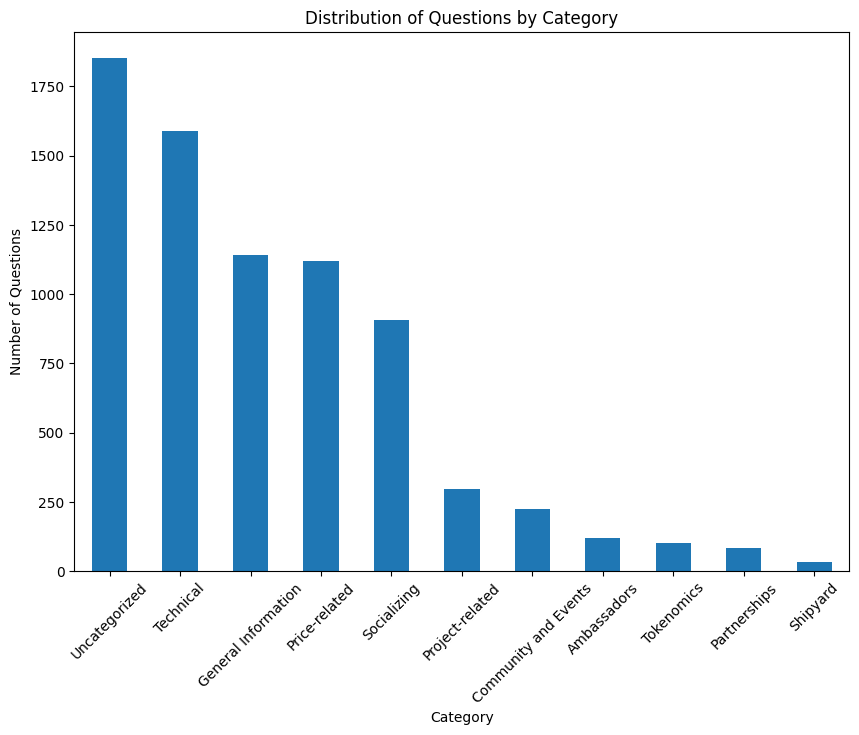

In [ ]:
# Filter messages that contain questions
questions = dataset[dataset['Content'].str.contains('\?')].copy()

# Define keywords for each category
keywords = {
    'Partnerships': [
        'partnership', 'partnerships', 'marketing'
    ],
    'Shipyard': [
        'shipyard',
    ],
    'Technical': [
        'api', 'error', 'bug', 'smart contract', 'nft', 'wallet', 'technical', 'transfer', 'ownership', 'tool',
        'update', 'upgrade', 'version', 'release', 'deploy', 'code', 'github', 'repository', 'programming',
        'blockchain', 'ethereum', 'solidity', 'web3', 'dataset', 'compute2data', 'c2d', 'aquariums', 'provider',
        'ocean.py', 'ocean.js', 'ocean.cli'
    ],
    'Price-related': [
        'price', 'market', 'value', 'cost', 'trading', 'investment', 'token', 'stake', 'staking', 'liquidity',
        'pool', 'apy', 'roi', 'earnings', 'financial', 'trade', 'sell', 'buy', 'exchange', 'cryptocurrency', 'fiat'
    ],
    'General Information': [
        'how to', 'what is', 'when', 'where', 'guide', 'help', 'information', 'tutorial', 'start', 'join',
        'beginner', 'advice', 'recommendation', 'introduction', 'overview', 'summary', 'faq', 'question', 'inquiry'
    ],
    'Project-related': [
        'project', 'roadmap', 'feature', 'update', 'announcement', 'launch', 'development', 'future', 'plans',
        'vision', 'mission', 'goal', 'partnership', 'collaboration', 'team', 'developer', 'contribution'
    ],
    'Community and Events': [
        'community', 'event', 'meetup', 'conference', 'webinar', 'workshop', 'ama', 'session', 'talk',
        'presentation', 'forum', 'discussion', 'networking', 'participation', 'join', 'support', 'volunteer'
    ],
    'Tokenomics': [
        'token', 'tokens', 'tokenomics', 'supply', 'circulation', 'cap', 'staking', 'rewards', 'distribution',
        'governance', 'dao', 'vesting', 'economics'
    ],
    'Socializing': [
        'hi', 'hello', 'hey', 'guys', 'good morning', 'good evening', 'greetings'
    ],
    'Ambassadors': [
        'ambassador', 'ambassadors', 'application', 'treassure', 'hunter'
    ]
}


# Function to categorize questions based on keywords
def categorize_question(text, keywords):
    for category, keyword_list in keywords.items():
        if any(keyword in text.lower() for keyword in keyword_list):
            return category
    return 'Uncategorized'

# Apply categorization
questions['Category'] = questions['Content'].apply(lambda x: categorize_question(x, keywords))

# Count the number of questions in each category
category_counts = questions['Category'].value_counts()

# Plot the results
plt.figure(figsize=(10, 7))
category_counts.plot(kind='bar')
plt.title('Distribution of Questions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.show()


# Community activity

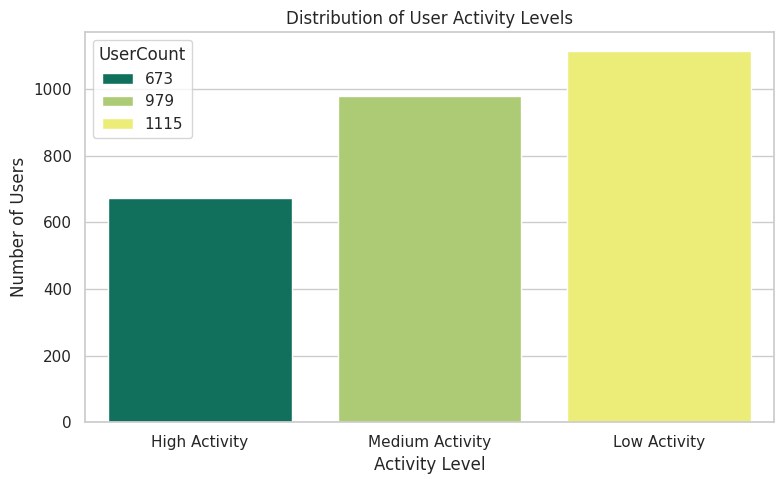

In [ ]:
# Filter out messages from the user named "deleted user"
users_dataset = dataset[dataset['AuthorName'].str.lower() != 'deleted user'].copy()
users_dataset['AttachmentsSent'] = users_dataset['HasAttachment'].astype(int)


if 'DateTime' not in users_dataset.columns:
  users_dataset = users_dataset.reset_index()

# Group the data by 'AuthorID' and 'AuthorName' to aggregate metrics
grouped_users = users_dataset.groupby(['AuthorID', 'AuthorName']).agg(
    MessagesSent=pd.NamedAgg(column='Content', aggfunc='count'),
    TotalWordCount=pd.NamedAgg(column='WordCount', aggfunc='sum'),
    TotalCharCount=pd.NamedAgg(column='CharCount', aggfunc='sum'),
    AttachmentsSent=pd.NamedAgg(column='AttachmentsSent', aggfunc='sum'),
    ReactionsReceived=pd.NamedAgg(column='ReactionCount', aggfunc='sum')
).reset_index()

# Reclassification based on quantile thresholds
def classify_users_by_activity_quantiles(df):
    # Determine the quantile thresholds
    quantile_25 = df['MessagesSent'].quantile(0.25)
    quantile_75 = df['MessagesSent'].quantile(0.75)

    # Initialize the classification column
    df['ActivityLevel'] = 'Low Activity'  # Default to Low Activity

    # Apply classifications based on quantiles
    df.loc[df['MessagesSent'] > quantile_75, 'ActivityLevel'] = 'High Activity'
    df.loc[(df['MessagesSent'] > quantile_25) & (df['MessagesSent'] <= quantile_75), 'ActivityLevel'] = 'Medium Activity'

    return df

# Assuming 'grouped_users' contains the aggregated user data with MessagesSent
user_activity_levels = classify_users_by_activity_quantiles(grouped_users.copy())

def plot_user_activity_levels(activity_levels_df):
    # Count the number of users in each activity level
    activity_levels_counts = activity_levels_df['ActivityLevel'].value_counts().reset_index()
    activity_levels_counts.columns = ['ActivityLevel', 'UserCount']

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(x='ActivityLevel', y='UserCount', data=activity_levels_counts, order=['High Activity', 'Medium Activity', 'Low Activity'], palette='summer', hue='UserCount')
    plt.title('Distribution of User Activity Levels')
    plt.xlabel('Activity Level')
    plt.ylabel('Number of Users')
    plt.tight_layout()
    plt.show()

# Plot the distribution of user activity levels
plot_user_activity_levels(user_activity_levels)


## Users ranking


* Messages Sent
* Words Sent
* Characters Sent
* Attachments Sent
* Reactions Received

In [ ]:
if 'DateTime' in users_dataset.columns:
  users_dataset.set_index('DateTime', inplace=True)

# Calculate various metrics for each user
user_messages = users_dataset.groupby('AuthorName').size()
user_words = users_dataset.groupby('AuthorName')['WordCount'].sum()
user_characters = users_dataset.groupby('AuthorName')['CharCount'].sum()
user_attachments = users_dataset.groupby('AuthorName')['HasAttachment'].sum()
user_reactions = users_dataset.groupby('AuthorName')['ReactionCount'].sum()

# Compiling the metrics into a single DataFrame
user_rankings = pd.DataFrame({
    'MessagesSent': user_messages,
    'WordsSent': user_words,
    'CharactersSent': user_characters,
    'AttachmentsSent': user_attachments,
    'ReactionsReceived': user_reactions
})

# Displaying the top users by each metric
user_rankings.sort_values(by='MessagesSent', ascending=False).head(15)

,MessagesSent,WordsSent,CharactersSent,AttachmentsSent,ReactionsReceived
AuthorName,,,,,
blockchainlugano,1199,37092,219677,20,782
kreigdk,1106,24580,162288,32,277
dotunwilfred.eth,1044,36381,271737,305,153
zippy1979,847,11151,65177,11,290
bhavingala,837,11037,92881,50,97
robinlehmann,830,22436,134804,8,249
lukas85#6738,795,7680,47038,5,31
doteth,647,18194,117544,20,410
birususama,529,15086,101738,4,50


## User ranking per category

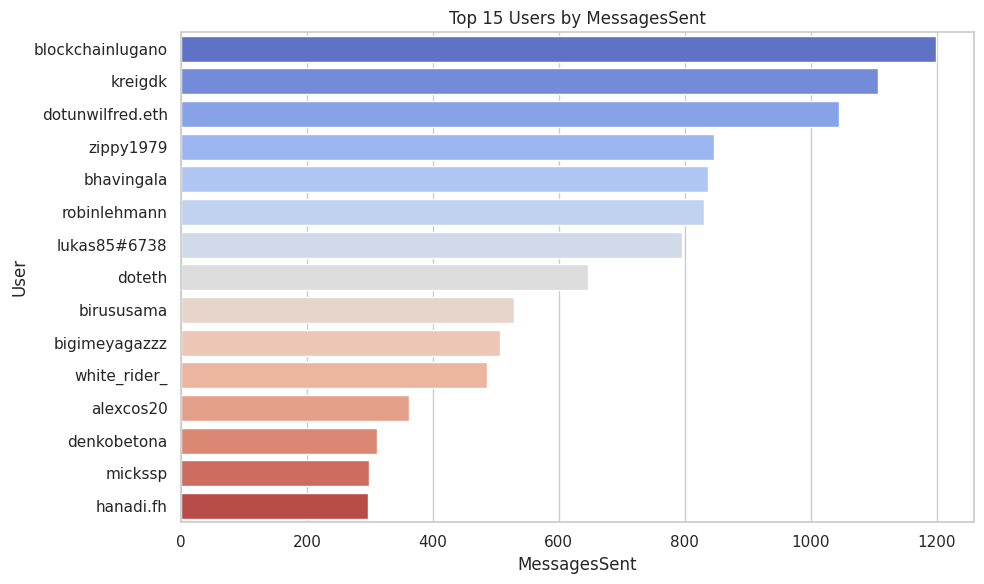

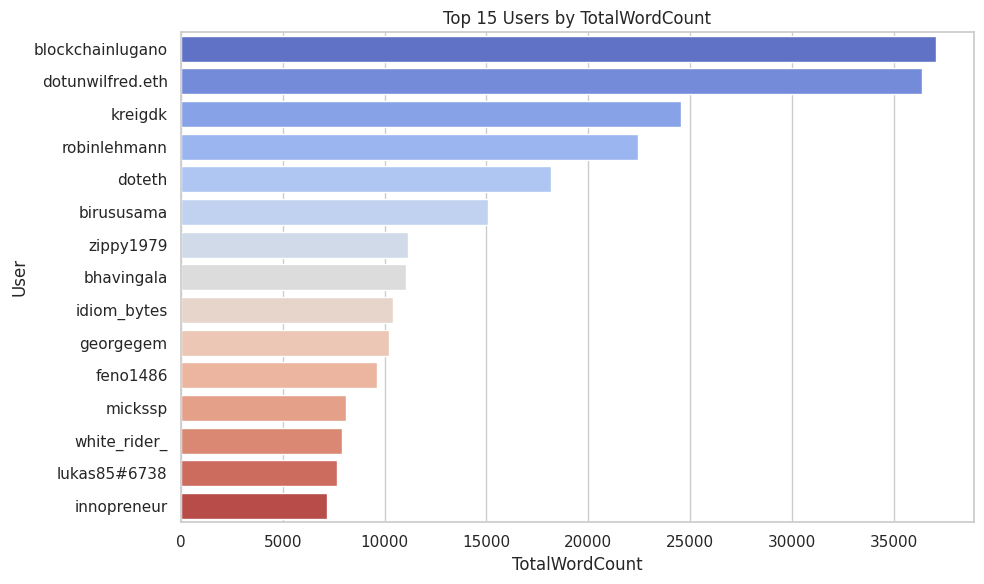

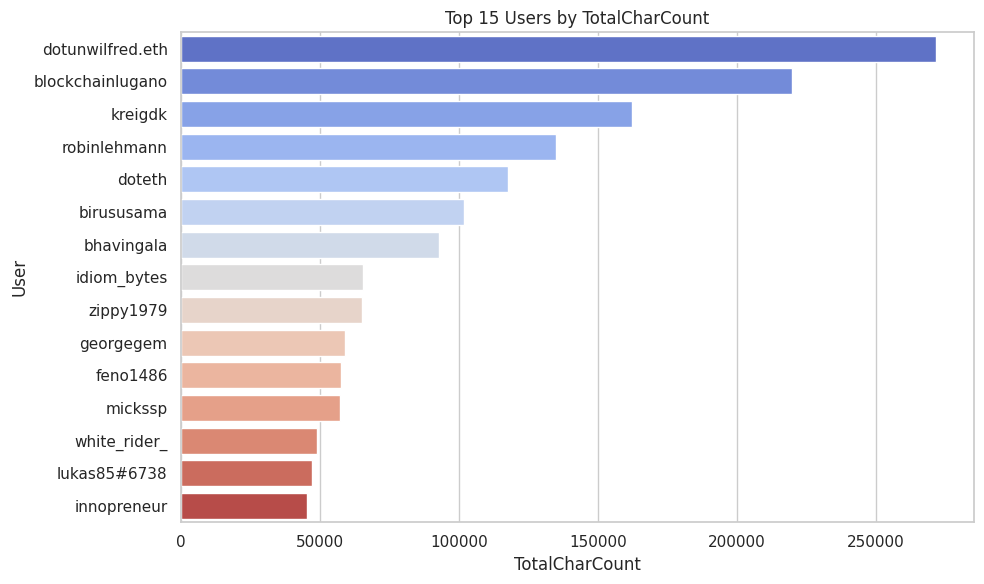

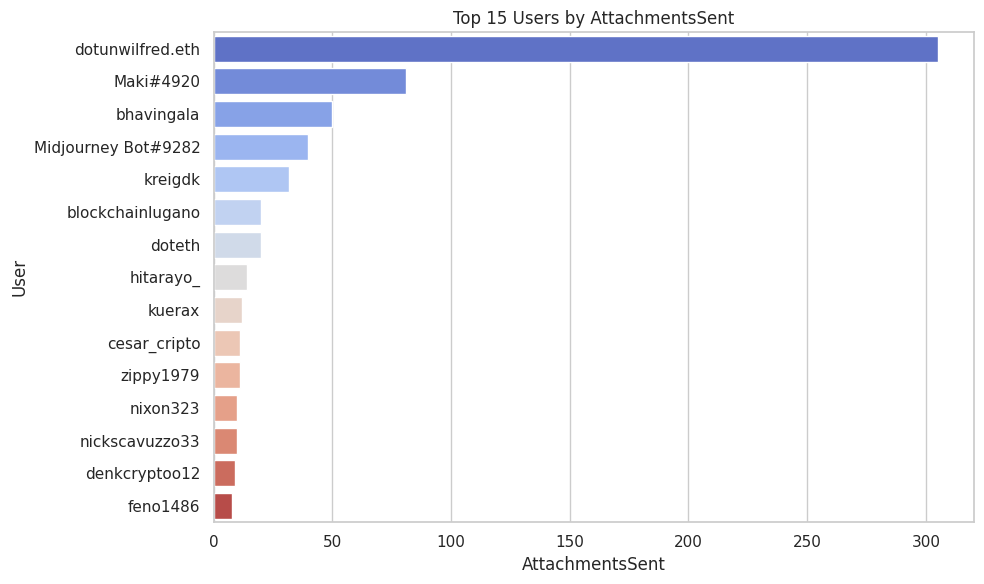

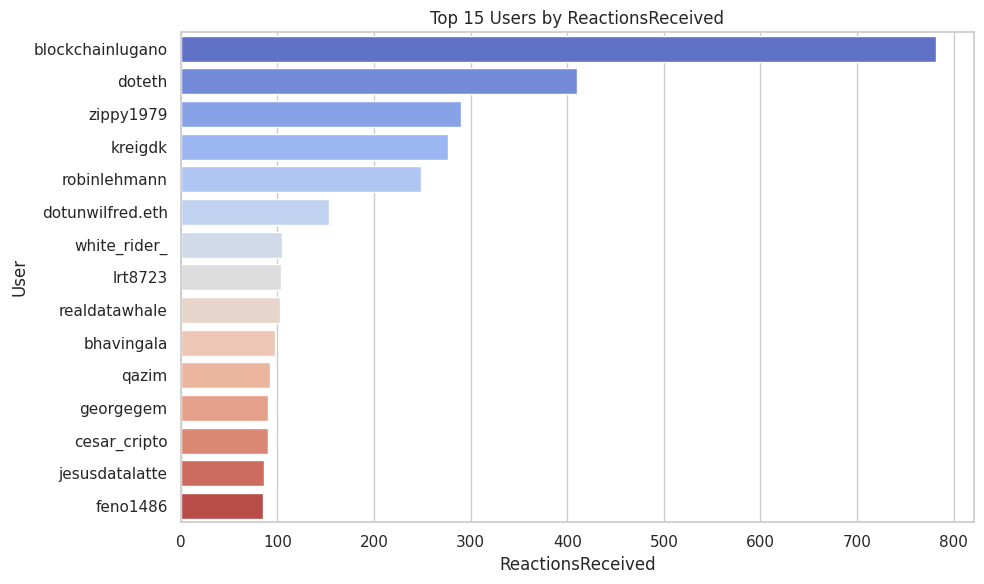

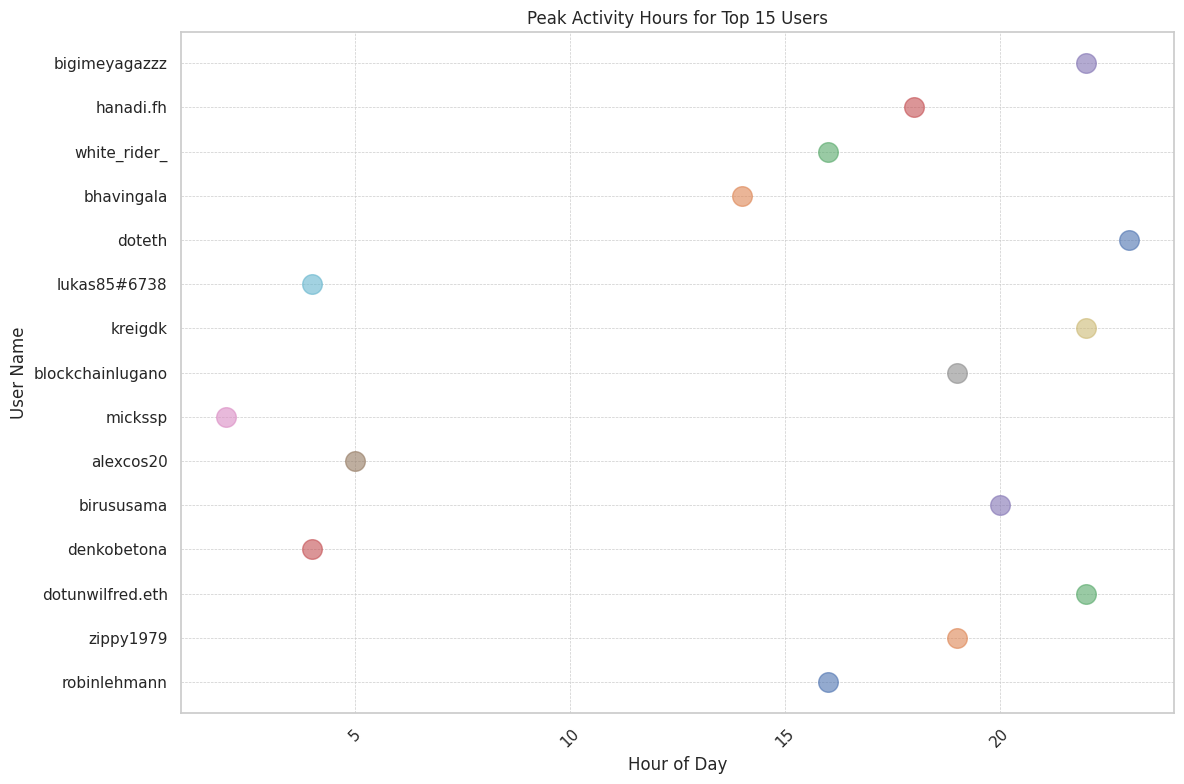

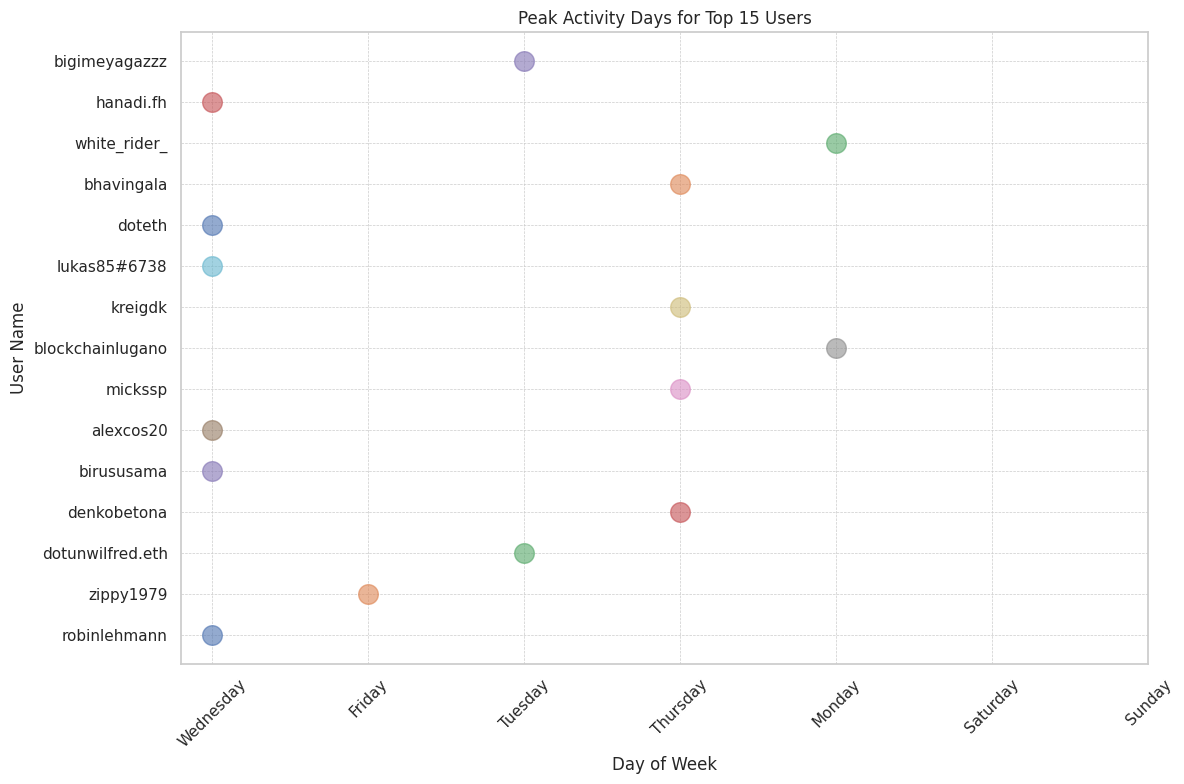

In [ ]:
if 'DateTime' not in users_dataset.columns:
  users_dataset = users_dataset.reset_index()

# Group the data by 'AuthorID' and 'AuthorName' to aggregate metrics
grouped_users = users_dataset.groupby(['AuthorID', 'AuthorName']).agg(
    MessagesSent=pd.NamedAgg(column='Content', aggfunc='count'),
    TotalWordCount=pd.NamedAgg(column='WordCount', aggfunc='sum'),
    TotalCharCount=pd.NamedAgg(column='CharCount', aggfunc='sum'),
    AttachmentsSent=pd.NamedAgg(column='AttachmentsSent', aggfunc='sum'),
    ReactionsReceived=pd.NamedAgg(column='ReactionCount', aggfunc='sum')
).reset_index()

# Ranking the top 15 users by each metric
top_metrics = ['MessagesSent', 'TotalWordCount', 'TotalCharCount', 'AttachmentsSent', 'ReactionsReceived']
top_users = {metric: grouped_users.sort_values(by=metric, ascending=False).head(15) for metric in top_metrics}

# Extract top 15 user IDs based on Messages Sent for time analysis
top_15_user_ids_messages = top_users['MessagesSent']['AuthorID'].unique()

# Filter dataset for these top 15 users
df_top_15 = users_dataset[users_dataset['AuthorID'].isin(top_15_user_ids_messages)]

# Group by user and hour/day for peak activity analysis
peak_hours = df_top_15.groupby(['AuthorID', df_top_15['DateTime'].dt.hour]).agg(MessagesSent=pd.NamedAgg(column='Content', aggfunc='count')).reset_index()
peak_days = df_top_15.groupby(['AuthorID', df_top_15['DateTime'].dt.dayofweek]).agg(MessagesSent=pd.NamedAgg(column='Content', aggfunc='count')).reset_index()

# Find peak activity hours and days for each user
peak_activity_hours = peak_hours.loc[peak_hours.groupby('AuthorID')['MessagesSent'].idxmax()]
peak_activity_days = peak_days.loc[peak_days.groupby('AuthorID')['MessagesSent'].idxmax()]

# Visualization settings
sns.set(style="whitegrid")

# Function for plotting top users based on a metric
def plot_top_users(df, metric, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x=metric, y="AuthorName", data=df.sort_values(by=metric, ascending=False), palette="coolwarm", hue='AuthorName')
    plt.title(title)
    plt.xlabel(metric)
    plt.ylabel("User")
    plt.tight_layout()
    plt.show()

# Plotting the top users by each metric
for metric, df_metric in top_users.items():
    plot_top_users(df_metric, metric, f"Top 15 Users by {metric}")

# Merge peak activity hours and days with the author names
peak_activity_hours_with_names = peak_activity_hours.merge(grouped_users[['AuthorID', 'AuthorName']], on='AuthorID', how='left')
peak_activity_days_with_names = peak_activity_days.merge(grouped_users[['AuthorID', 'AuthorName']], on='AuthorID', how='left')
peak_activity_days_with_names['DayOfWeekStr'] = peak_activity_days_with_names['DateTime'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])

# peak_activity_days_with_names = peak_activity_days.merge(grouped_users[['AuthorID', 'AuthorName']], on='AuthorID', how='left')

# Adjusted plotting functions using the merged DataFrames
def plot_peak_hours(df):
    plt.figure(figsize=(12, 8))
    for _, row in df.iterrows():
        plt.scatter(row['DateTime'], row['AuthorName'], alpha=0.6, s=200)  # Now using 'DateTime' for x-axis
    plt.title('Peak Activity Hours for Top 15 Users')
    plt.xlabel('Hour of Day')
    plt.ylabel('User Name')
    plt.xticks(rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Correct the creation of 'DayOfWeek' column to ensure it exists and contains the correct data for plotting
def plot_peak_days(df):
    plt.figure(figsize=(12, 8))
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    unique_names = df['AuthorName'].unique()
    for name in unique_names:
        day_week = df[df['AuthorName'] == name]['DayOfWeekStr'].iloc[0]  # Get the corresponding day of week for the author
        plt.scatter(day_week, name, alpha=0.6, s=200)
    plt.title('Peak Activity Days for Top 15 Users')
    plt.xlabel('Day of Week')
    plt.ylabel('User Name')
    plt.xticks(day_order, rotation=45)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Now plot using the merged DataFrames
plot_peak_hours(peak_activity_hours_with_names)
plot_peak_days(peak_activity_days_with_names)


## Activity Classification

,AuthorID,AuthorName,ActivityClassification
0,194817764236460034,robinlehmann,Daytime Active
1,209963946432528384,zippy1979,Evening Active
2,344879785173843970,dotunwilfred.eth,Evening Active
3,368405653217345536,denkobetona,Night Owl
4,387401160656683034,birususama,Evening Active
5,625415196713943051,alexcos20,Early Bird
6,647661378198306821,mickssp,Night Owl
7,717363377269244015,blockchainlugano,Evening Active
8,739132787499597824,kreigdk,Evening Active
9,768163222095134732,lukas85#6738,Night Owl


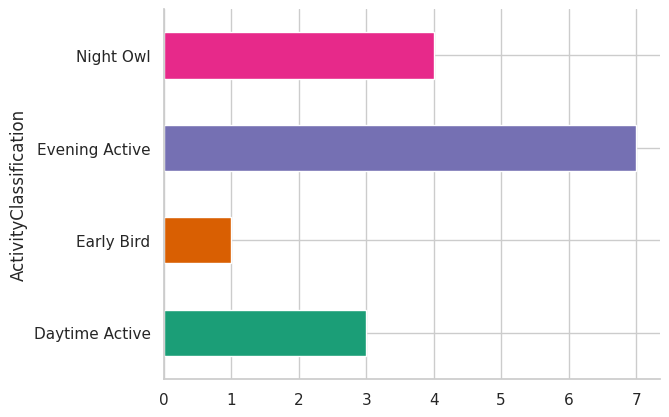

In [ ]:
def classify_activity(peak_hours_df, peak_days_df):
    # Merge peak hours and days dataframes to have a complete view
    activity_df = peak_hours_df.merge(peak_days_df[['AuthorID', 'DayOfWeekStr']], on='AuthorID', how='left')

    # Initialize a column for the activity classification
    activity_df['ActivityClassification'] = 'Undefined'

    for index, row in activity_df.iterrows():
        hour = int(row['DateTime'])
        if 5 <= hour < 10:
          activity_df.at[index, 'ActivityClassification'] = 'Early Bird'
        elif 10 <= hour < 18:
          activity_df.at[index, 'ActivityClassification'] = 'Daytime Active'
        elif 18 <= hour < 23:
          activity_df.at[index, 'ActivityClassification'] = 'Evening Active'
        else:
          activity_df.at[index, 'ActivityClassification'] = 'Night Owl'


    # Further classify or adjust classification based on peak days (if needed)
    weekend_days = ['Saturday', 'Sunday']
    activity_df.loc[activity_df['DayOfWeekStr'].isin(weekend_days) & (activity_df['ActivityClassification'] == 'Undefined'), 'ActivityClassification'] = 'Weekend Warrior'

    # Fill remaining undefined classifications with 'Weekday Active' as a default
    activity_df.loc[activity_df['ActivityClassification'] == 'Undefined', 'ActivityClassification'] = 'Weekday Active'

    return activity_df[['AuthorID', 'AuthorName', 'ActivityClassification']].drop_duplicates()

# Adjust the creation of peak_activity_days_with_names to include 'DayOfWeekStr'
peak_activity_days_with_names['DayOfWeekStr'] = peak_activity_days_with_names['DateTime'].apply(lambda x: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][x])

# Classify user activity
user_activity_classification = classify_activity(peak_activity_hours_with_names, peak_activity_days_with_names)

# Display the classified user activity
user_activity_classification.groupby('ActivityClassification').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

user_activity_classification


## Users activity -  evolution


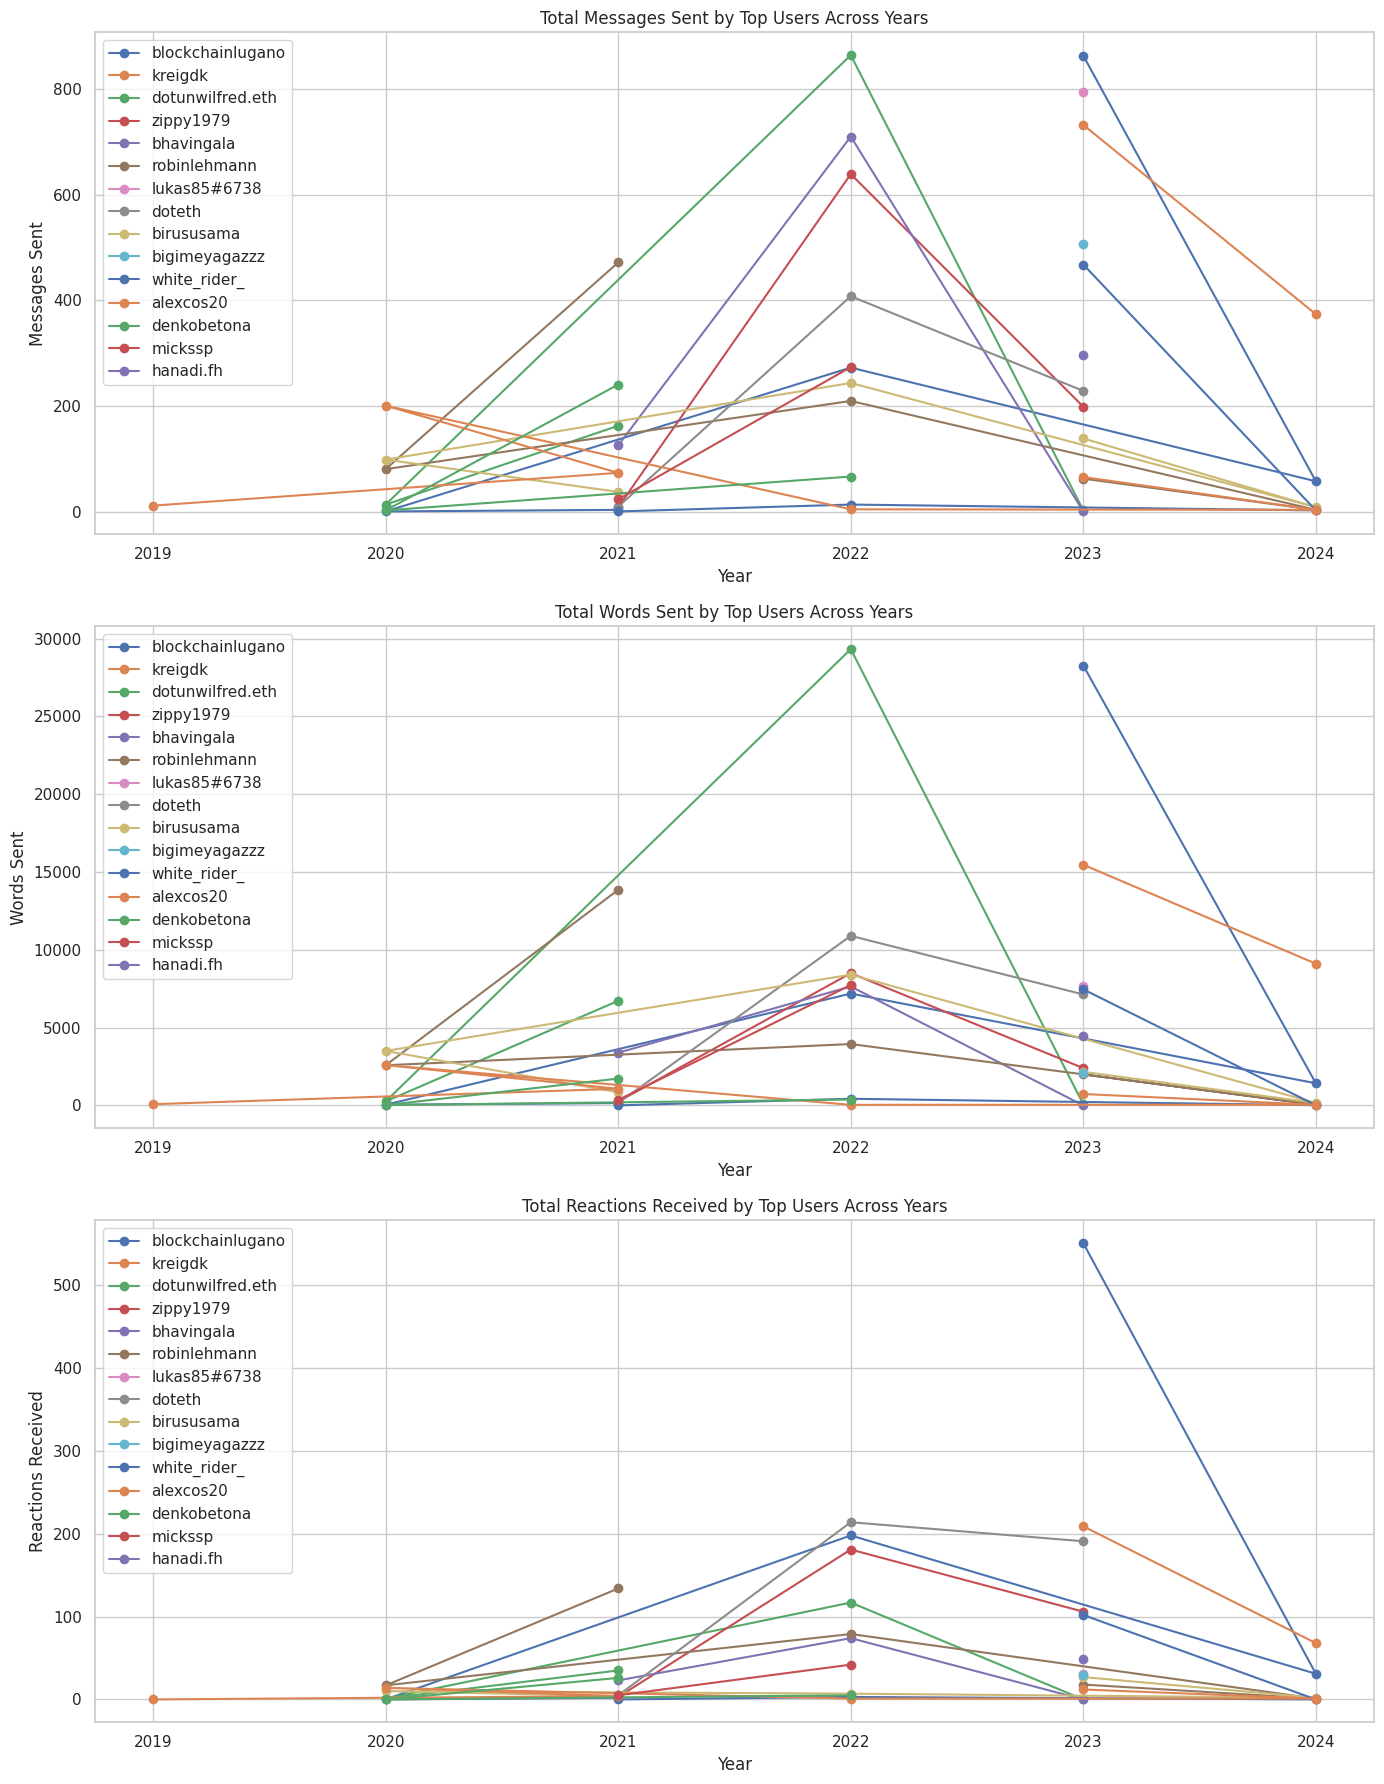

In [ ]:
# Initializing an empty DataFrame to store aggregated yearly metrics
yearly_metrics = pd.DataFrame()

# Loop through each year present in the dataset
for year in users_dataset['Year'].unique():
    # Filter the dataset for the current year
    yearly_data = users_dataset[users_dataset['Year'] == year]

    # Calculating metrics for the current year
    messages_sent = yearly_data.groupby('AuthorName').size()
    words_sent = yearly_data.groupby('AuthorName')['WordCount'].sum()
    characters_sent = yearly_data.groupby('AuthorName')['CharCount'].sum()
    attachments_sent = yearly_data.groupby('AuthorName')['HasAttachment'].sum()
    reactions_received = yearly_data.groupby('AuthorName')['ReactionCount'].sum()

    # Compiling metrics into a DataFrame for the current year
    yearly_summary = pd.DataFrame({
        'MessagesSent': messages_sent,
        'WordsSent': words_sent,
        'CharactersSent': characters_sent,
        'AttachmentsSent': attachments_sent,
        'ReactionsReceived': reactions_received
    }).reset_index().assign(Year=year)

    # Appending the yearly summary to the aggregated DataFrame
    yearly_metrics = pd.concat([yearly_metrics, yearly_summary], ignore_index=True)

# Displaying the aggregated yearly metrics for the top users by messages sent for each year
yearly_metrics.sort_values(by=['Year', 'MessagesSent'], ascending=[True, False]).head(15)

# Identifying the overall top users based on total messages sent across all years
top_users_overall = yearly_metrics.groupby('AuthorName')['MessagesSent'].sum().nlargest(15).index.tolist()

# Filtering the yearly_metrics DataFrame to include only these top users
filtered_yearly_metrics = yearly_metrics[yearly_metrics['AuthorName'].isin(top_users_overall)]

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(14, 18))

# Messages Sent by Top Users Across Years
for user in top_users_overall:
    user_data = filtered_yearly_metrics[filtered_yearly_metrics['AuthorName'] == user]
    axes[0].plot(user_data['Year'], user_data['MessagesSent'], marker='o', linestyle='-', label=user)
axes[0].set_title('Total Messages Sent by Top Users Across Years')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Messages Sent')
axes[0].legend()

# Words Sent by Top Users Across Years
for user in top_users_overall:
    user_data = filtered_yearly_metrics[filtered_yearly_metrics['AuthorName'] == user]
    axes[1].plot(user_data['Year'], user_data['WordsSent'], marker='o', linestyle='-', label=user)
axes[1].set_title('Total Words Sent by Top Users Across Years')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Words Sent')
axes[1].legend()

# Reactions Received by Top Users Across Years
for user in top_users_overall:
    user_data = filtered_yearly_metrics[filtered_yearly_metrics['AuthorName'] == user]
    axes[2].plot(user_data['Year'], user_data['ReactionsReceived'], marker='o', linestyle='-', label=user)
axes[2].set_title('Total Reactions Received by Top Users Across Years')
axes[2].set_xlabel('Year')
axes[2].set_ylabel('Reactions Received')
axes[2].legend()

plt.tight_layout()
plt.show()


## Users yearly evolution


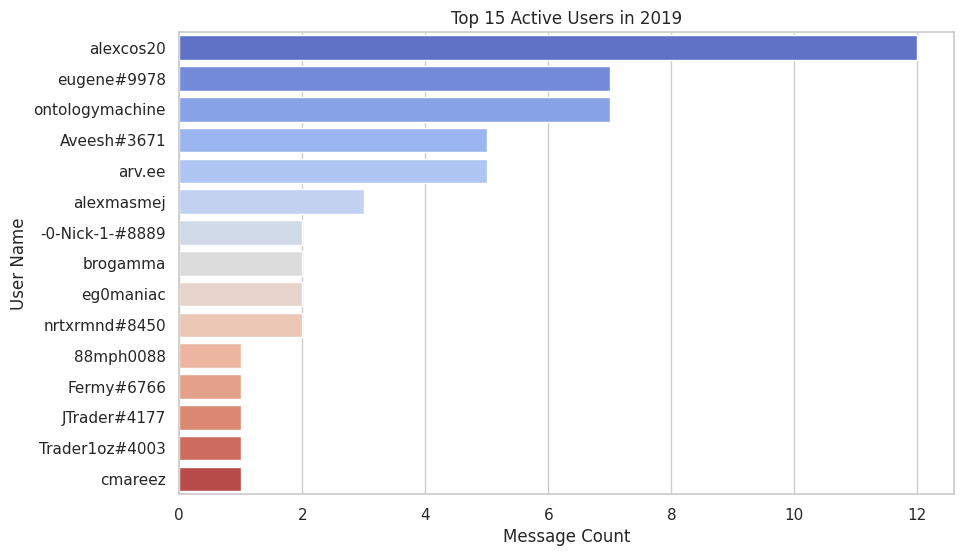

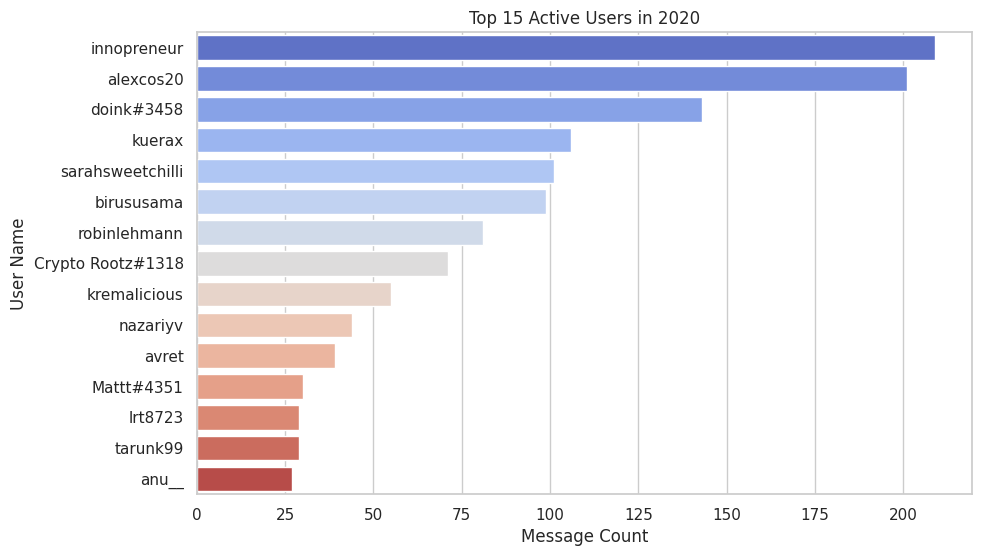

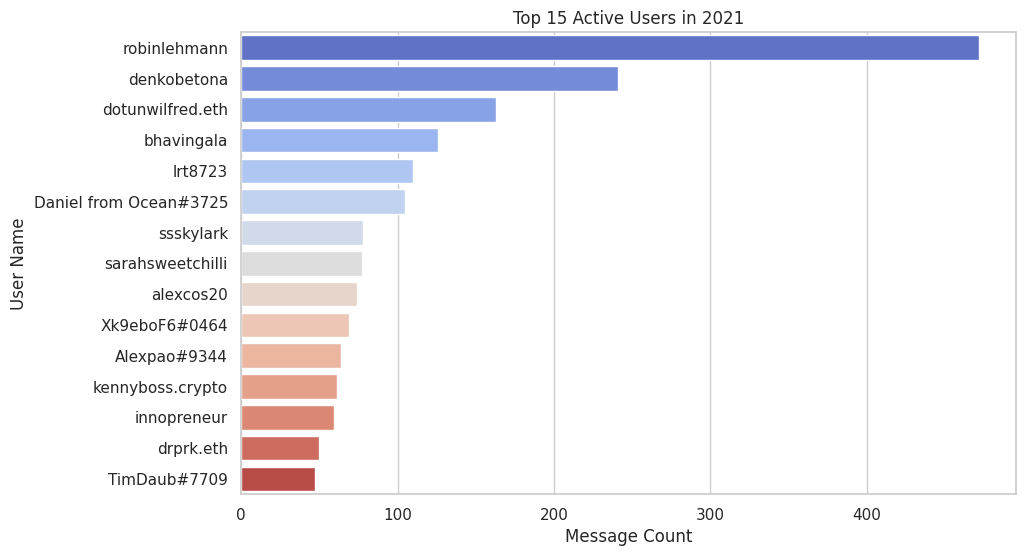

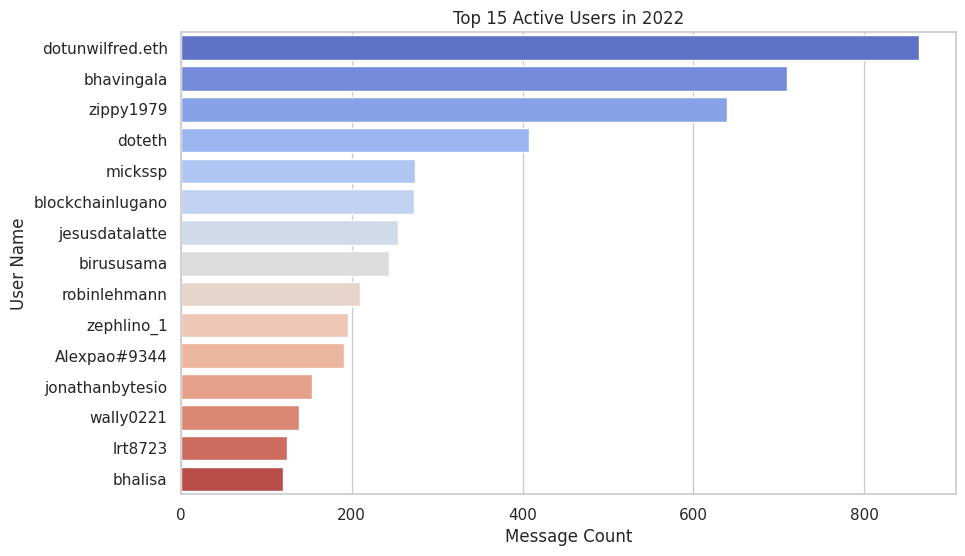

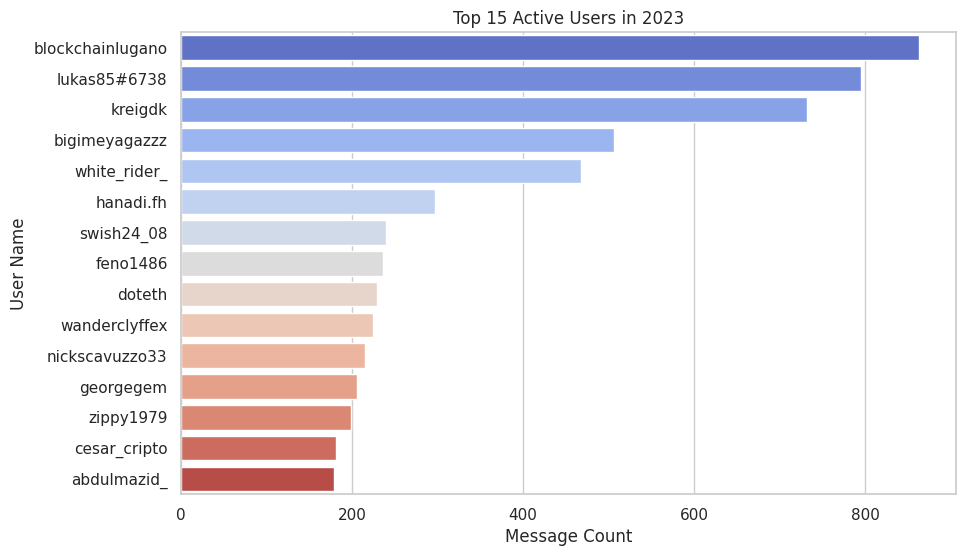

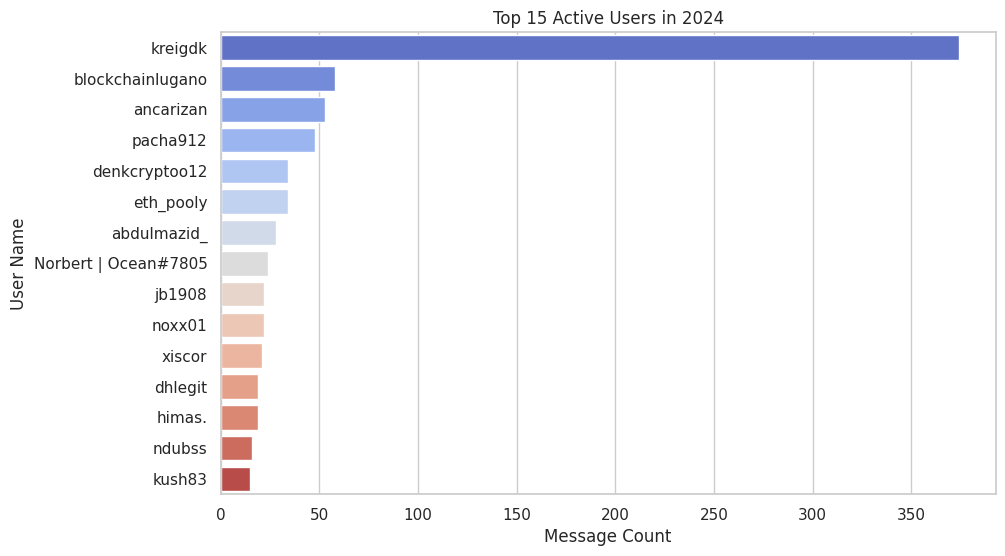

In [ ]:
# Count the number of messages per user per year
user_activity_per_year = users_dataset.groupby(['Year', 'AuthorName']).size().reset_index(name='MessageCount')

# Now, for each year, find the top 10 active users
top_users_per_year = user_activity_per_year.groupby('Year').apply(
    lambda x: x.nlargest(15, 'MessageCount')).reset_index(drop=True)

# Since plotting all years in one plot might be cluttered, let's first check which years are available in the dataset.
years_available = top_users_per_year['Year'].unique()

# Plot for each year
for year in years_available:
    # Filter the data for the current year
    data_year = top_users_per_year[top_users_per_year['Year'] == year]

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MessageCount', y='AuthorName', data=data_year, palette='coolwarm', hue='AuthorName')

    # Set title and labels
    plt.title(f'Top 15 Active Users in {year}')
    plt.xlabel('Message Count')
    plt.ylabel('User Name')

    # Show plot
    plt.show()

# Scam & Spam

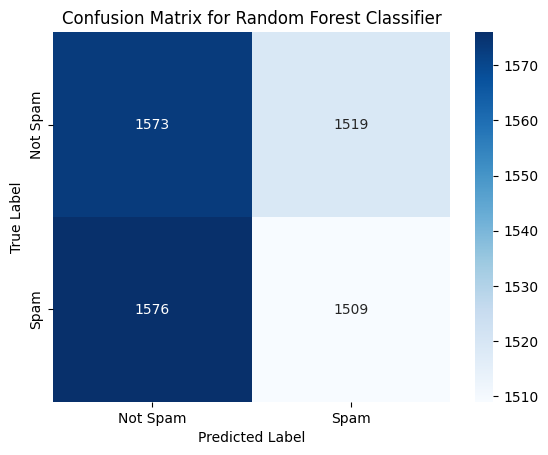

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.ensemble import RandomForestClassifier

# Reload the dataset
file_path = 'chat_and_price_history.csv'
data = pd.read_csv(file_path)

# Create mock labels for demonstration
np.random.seed(42)
data['IsSpam'] = np.random.choice([0, 1], size=len(data))

# Selecting features and labels
features = data[['Content', 'WordCount', 'CharCount', 'ReactionCount', 'HasAttachment']]
labels = data['IsSpam']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Preprocessing text data with TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train['Content'])
X_test_tfidf = vectorizer.transform(X_test['Content'])

# Convert 'HasAttachment' to an integer
X_train['HasAttachmentInt'] = X_train['HasAttachment'].astype(int)
X_test['HasAttachmentInt'] = X_test['HasAttachment'].astype(int)

# Combining TF-IDF features with numerical features
X_train_combined = hstack((X_train_tfidf, X_train[['WordCount', 'CharCount', 'ReactionCount', 'HasAttachmentInt']].values))
X_test_combined = hstack((X_test_tfidf, X_test[['WordCount', 'CharCount', 'ReactionCount', 'HasAttachmentInt']].values))

# Training the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_combined, y_train)

# Predicting on the test set
y_pred = rf_classifier.predict(X_test_combined)

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Technical issues


<ipython-input-11-4bb3beb5c99d>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['CleanedContent'] = filtered_data['Content'].apply(preprocess_text)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-11-4bb3beb5c99d>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Cluster'] = kmeans

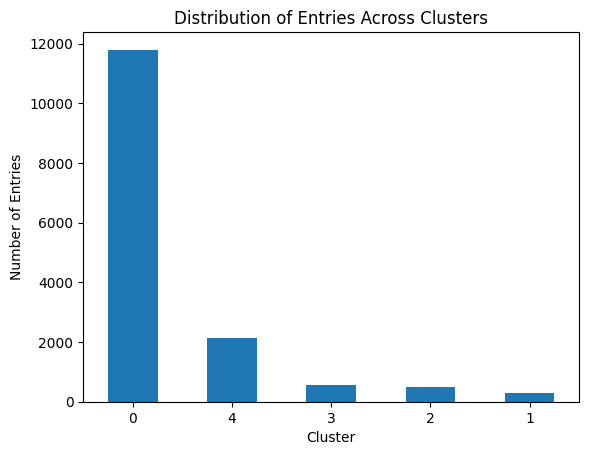

In [ ]:
data = pd.read_csv('chat_and_price_history.csv')
data['DateTime'] = pd.to_datetime(data['DateTime'])

# Filter data for the specified date range
start_date = '2023-01-01'
end_date = data['DateTime'].max()  # Adjust based on your data
filtered_data = data[(data['DateTime'] >= start_date) & (data['DateTime'] <= end_date)]

# Preprocess text data
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    return text

filtered_data['CleanedContent'] = filtered_data['Content'].apply(preprocess_text)

# Extract features using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.5, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(filtered_data['CleanedContent'].values.astype('U'))

# Apply K-means clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(tfidf_matrix)
filtered_data['Cluster'] = kmeans.labels_

# Plot the distribution of data points among the clusters
cluster_distribution = filtered_data['Cluster'].value_counts()
cluster_distribution.plot(kind='bar')
plt.title('Distribution of Entries Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Entries')
plt.xticks(rotation=0)
plt.show()


# Prediction model
The dataset contains 30,883 entries and 18 columns, detailing various aspects of chat activity and Ocean Protocol's price at different times. The key columns include:


Model Selection Rationale
Considering the temporal nature of the data and likely patterns such as daily or weekly cycles in chat activity, models that can capture seasonality, trend, and cyclic behavior would be appropriate. Choices include:

* ARIMA/SARIMA: Good for univariate time series data without external influences if the series is stationary or made stationary through differencing. SARIMA is particularly suited if the data exhibits seasonality.
* Prophet: Developed by Facebook, it's particularly user-friendly for forecasting with daily observations that display patterns on different time scales such as holidays, weekends, etc. It can handle outliers, missing data, and shifts in the trend well.
* LSTM (Long Short-Term Memory) Neural Networks: Suitable for capturing complex patterns in time series data, especially if there are long-term dependencies.


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzntf1pwv/i8lncy_a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpzntf1pwv/30r_xm6y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35598', 'data', 'file=/tmp/tmpzntf1pwv/i8lncy_a.json', 'init=/tmp/tmpzntf1pwv/30r_xm6y.json', 'output', 'file=/tmp/tmpzntf1pwv/prophet_modeljhhuxvu3/prophet_model-20240310123307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:33:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:33:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


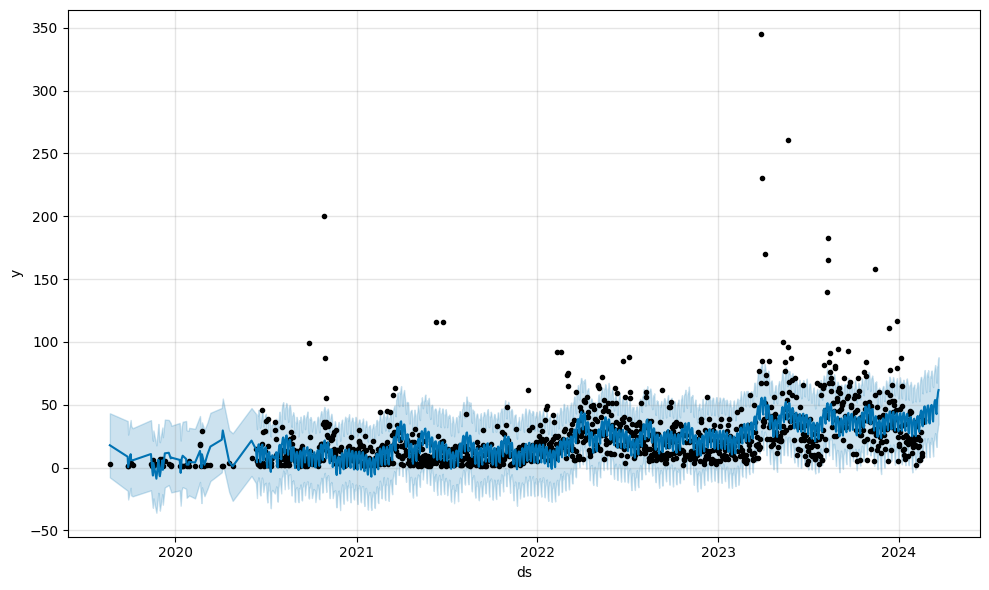

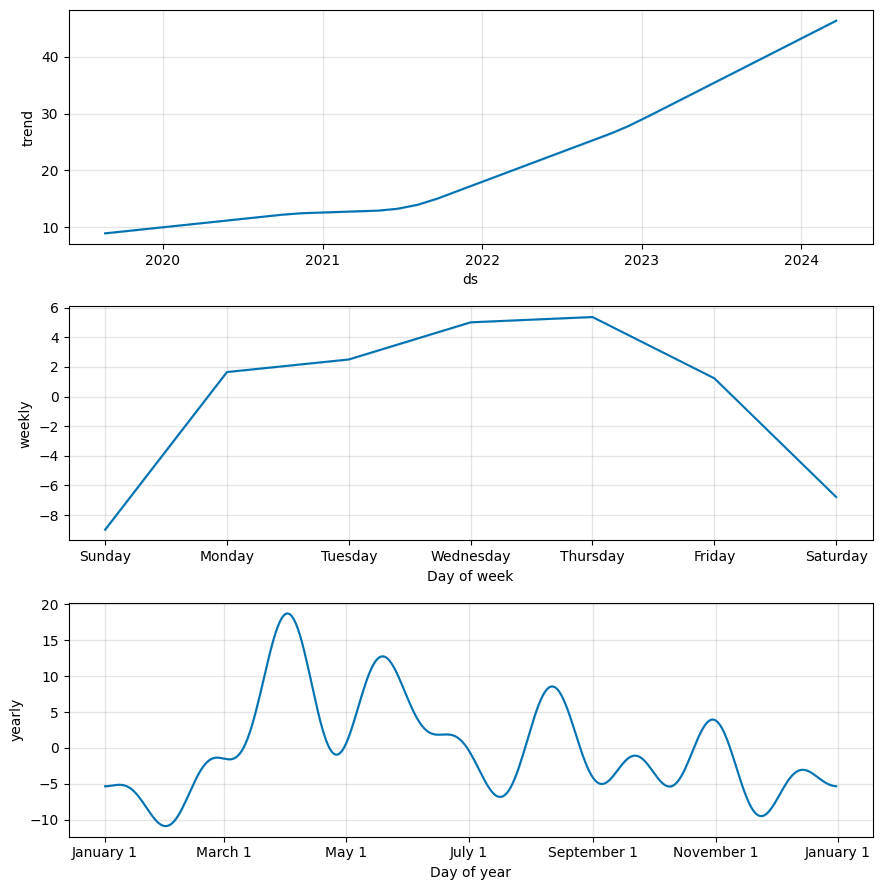

In [ ]:
# Load the dataset
file_path = 'chat_and_price_history.csv'
data = pd.read_csv(file_path)

# Convert 'DateTime' to datetime type and aggregate data by day
data['DateTime'] = pd.to_datetime(data['DateTime'])
daily_data = data.groupby(data['DateTime'].dt.date).size().reset_index(name='MessageCount')

# Rename columns for Prophet
daily_data.rename(columns={'DateTime': 'ds', 'MessageCount': 'y'}, inplace=True)

# Initialize and fit the Prophet model
model = Prophet()
model.fit(daily_data)

# Make a future dataframe for the next 30 days
future = model.make_future_dataframe(periods=30)

# Forecast the future
forecast = model.predict(future)
forecast.head()

# Plot the forecast
fig = model.plot(forecast)
fig2 = model.plot_components(forecast)